# Recocido Simulado

## Cargamos paqueterías necesarias

In [38]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import pandas as pd 


## Funciones de Prueba

In [3]:

# Funciones de prueba
@jit(nopython=True)
def Sphere(arr):
    suma = 0.0
    for x in arr:
        suma += x ** 2
    return suma

intervaloSphere = (-5.12, 5.12)

@jit(nopython=True)
def Ackley(arr):
    suma1 = 0.0
    suma2 = 0.0
    n = arr.shape[0]
    for x in arr:
        suma1 += x ** 2
        suma2 += np.cos(2 * np.pi * x)
    term1 = 20 + np.exp(1) - 20 * np.exp(-0.2 * np.sqrt(suma1 / n))
    term2 = np.exp(suma2 / n)
    return term1 - term2

intervaloAckley = (-30, 30)

@jit(nopython=True)
def Griewank(arr):
    suma = 0.0
    m = 1.0
    n = arr.shape[0]
    for i in range(1, n + 1):
        x_i = arr[i - 1]
        suma += (x_i ** 2) / 4000.0
        m *= np.cos(x_i / np.sqrt(i))
    return 1 + suma - m

intervaloGriewank = (-600, 600)

@jit(nopython=True)
def Rastrigin(arr):
    n = arr.shape[0]
    suma = 0.0
    for x in arr:
        suma += x ** 2 - 10 * np.cos(2 * np.pi * x)
    return 10 * n + suma

intervaloRastrigin = (-5.12, 5.12)

@jit(nopython=True)
def Rosenbrock(x):
    n = x.shape[0]
    suma = 0.0
    for i in range(n - 1):
        suma += 100 * (x[i + 1] - (x[i]) ** 2) ** 2 + (x[i] - 1) ** 2
    return suma

intervaloRosenbrock = (-2.048, 2.048)


### Codificación y decodificación de soluciones

In [4]:
# Codificación y decodificación binaria
@jit(nopython=True)
def codifica_real(x, n_bit, intervalo):
    a, b = intervalo
    precision = (b - a) / ((2 ** n_bit) - 1)
    x = max(a, min(b, x))
    index = int((x - a) / precision)
    x_binario = np.zeros(n_bit, dtype=np.int64)
    for i in range(n_bit - 1, -1, -1):
        x_binario[i] = index & 1
        index >>= 1
    return x_binario

@jit(nopython=True)
def codifica_vector(vector_reales, n_bit, intervalo):
    vector_binario = np.empty((len(vector_reales), n_bit), dtype=np.int64)
    for i in range(len(vector_reales)):
        vector_binario[i] = codifica_real(vector_reales[i], n_bit, intervalo)
    return vector_binario

@jit(nopython=True)
def decodifica(x_cod, n_bits, intervalo):
    a, b = intervalo
    precision = (b - a) / ((2 ** n_bits) - 1)
    indice = 0
    for i in range(len(x_cod)):
        indice = (indice << 1) | x_cod[i]
    return a + indice * precision

@jit(nopython=True)
def decodifica_vector(vector_binario, n_bits, intervalo):
    vector_reales = np.empty(vector_binario.shape[0])
    for i in range(vector_binario.shape[0]):
        vector_reales[i] = decodifica(vector_binario[i], n_bits, intervalo)
    return vector_reales

## Distancias y Entropia

In [5]:
@jit(nopython=True)
def distancia_ham_normalizada(sol1, sol2):
    # Suponiendo que sol1 y sol2 son arreglos de numpy
    if sol1.size != sol2.size:
        raise ValueError("Las soluciones deben tener el mismo tamaño")
    return np.sum(sol1 != sol2) / sol1.size

@jit(nopython=True)
def diversidad_promedio(poblacion):  # recibe una matriz de matrices
    n = poblacion.shape[0]  # tamaño de la población
    matriz = np.zeros((n, n))  # inicializamos matriz de distancias
    for i in range(n):  # Itera sobre cada individuo
        for j in range(i + 1, n):  # Solo itera sobre la mitad triangular superior derecha
            distancia = distancia_ham_normalizada(poblacion[i], poblacion[j])
            matriz[i][j] = distancia  # Almacena la distancia en la matriz
            matriz[j][i] = distancia  # La distancia es la misma de j a i
    suma = np.sum(matriz) / n  # suma todas las distancias y las normaliza
    suma_prom = suma / n  # obtiene promedio de las distancias normalizadas
    return suma_prom

@jit(nopython=True)
def diversidad_minima_promedio(poblacion):
    n = poblacion.shape[0]  # tamaño de la población
    lista_minimos = np.zeros(n)

    for i in range(n):  # para cada individuo
        minimo = np.inf 

        for j in range(n):  # lo comparamos con los demás
            if i != j:
                distancia = distancia_ham_normalizada(poblacion[i], poblacion[j])
                if distancia < minimo:  # si la distancia es menor a la mínima actual
                    minimo = distancia  # actualizamos el mínimo
        lista_minimos[i] = minimo  # asignamos el mínimo encontrado para el individuo i
    
    # Sacamos el promedio de los mínimos
    promedio = np.sum(lista_minimos) / n
    return promedio


In [6]:
# compilación AOT
ind1 = np.array( [[1,1,1],[1, 1, 1]])
ind2 = np.array( [[0,0,0],[0, 0, 0]])

distancia_ham_normalizada(ind1, ind2)

1.0

In [7]:
# compilación AOT
poblacion = np.array([ind1, ind1])

diversidad_minima_promedio(poblacion)

0.0

In [8]:
'''Función auxiliar para hacer el cálculo de la entropía por gen.'''

@jit(nopython=True)
def calcular_entropia_gen(genes):
    n = len(genes)
    p_0 = np.sum(genes == 0) / n
    p_1 = np.sum(genes == 1) / n
    
    entropia = 0
    if p_0 > 0:
        entropia -= p_0 * np.log2(p_0)
    if p_1 > 0:
        entropia -= p_1 * np.log2(p_1)
    
    return entropia



'''Recibe como parámetros: la población en arreglos de nBits.
   Retorna: la entropía total de la población.'''

@jit(nopython=True)
def Entropia_Total(poblacion):

    '''Primero, para facilitarnos la vida, vamos a pasar del esquema de cromosomas, a un
       esquema "aplanado". O sea cada individuo de la forma:
       [[0, 1, 1, 1, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0]]
       pasa a ser: [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]'''
    
    num_individuos = poblacion.shape[0]
    num_filas = poblacion.shape[1]
    num_columnas = poblacion.shape[2]

    # Creamos un array vacío para almacenar la población aplanada
    poblacion_aplanada = np.zeros((num_individuos, num_filas * num_columnas), dtype=np.int64)

    for i in range(num_individuos):
        indice = 0
        for j in range(num_filas):
            for k in range(num_columnas):
                poblacion_aplanada[i, indice] = poblacion[i, j, k]
                indice += 1

    # Teniendo a nuestra población aplanada, procedemos al cálculo de la entropía.
    
    _, num_genes = poblacion_aplanada.shape # Necesitamos el número de genes
    entropias_genes = np.zeros(num_genes) # Tendremos tantas entropías como genes.

    # Hacemos el cálculo de todas las entropías por gen:
    for gen_idx in range(num_genes): # Iteramos sobre cada posición del gen.
        # Tomamos todos los valores del gen en la misma posición de todos los individuos
        genes = poblacion_aplanada[:, gen_idx]
        # Calculamos la entropía de este gen
        entropias_genes[gen_idx] = calcular_entropia_gen(genes)

    
    # Obtenemos el valor de la entropía de la población:
    entropia_poblacion = np.mean(entropias_genes)

    return entropia_poblacion

In [9]:
# Ejemplo de uso (y compilación AOT)
poblacion = np.array([
    [[0, 1, 1, 1, 0],
     [1, 1, 0, 0, 0],
     [1, 0, 1, 1, 0],
     [1, 1, 1, 1, 0]],

    [[0, 1, 1, 1, 0],
     [1, 0, 1, 1, 0],
     [1, 1, 1, 1, 0],
     [1, 1, 0, 0, 0]],

    [[1, 0, 1, 1, 0],
     [1, 1, 0, 1, 0],
     [0, 1, 1, 1, 0],
     [1, 0, 1, 0, 0]]
])

entropiaPoblacional = Entropia_Total(poblacion)
print(entropiaPoblacional)

0.4591479170272449


In [10]:
# Función para generar una solución inicial
@jit(nopython=True)
def generar_solucion_inicial(n, n_bits, intervalo):
    solucion_reales = np.random.uniform(intervalo[0], intervalo[1], n)
    solucion_binaria = codifica_vector(solucion_reales, n_bits, intervalo)
    return solucion_binaria, solucion_reales

In [11]:
sol_bin, sol_real = generar_solucion_inicial(4, 20, (-3, 3))
decodifica_vector(sol_bin,20,(-3,3))

array([-0.26878478,  1.98342608, -0.44981332,  1.79038695])

In [12]:
@jit(nopython=True)
def generar_vecino(solucion_binaria, n_bits, intervalo):
    """
    Recibe una solucion inicial binaria y devuelve UN vecino aleatorio de la vecindad 1 flip 
    """
    n_variables = solucion_binaria.shape[0] 
    vecino_binario = solucion_binaria.copy() # partimos de una copia para modificar al vecino

    bit_a_mutar = np.random.randint(0, n_bits) # elegimos aleatoriamente el bit que vamos a modificar
    i = np.random.randint(0, n_variables) # Elegimos el escalar que vamos a cambiar
    vecino_binario[i][bit_a_mutar] = 1 - vecino_binario[i][bit_a_mutar]
    return vecino_binario


In [13]:
generar_vecino(sol_bin, 20, (-3,3))

array([[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1],
       [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]])

In [14]:

@jit(nopython=True)
def Recocido_Simulado(funcion, intervalo, dimension, n_bits, iteraciones, temperatura_inicial, esquema_enfriamiento, semilla = 0):
    # Si el usuario ingresa una semilla, entonces la fijamos
    if semilla != 0:
        np.random.seed(semilla)

    # Inicializamos a la mejor y actual soluciones como un vector aleatorio y guardamos sus evaluaciones
    sol_actual_binaria, sol_actual_real = generar_solucion_inicial(dimension, n_bits, intervalo)
    sol_mejor_binaria = sol_actual_binaria
    T = temperatura_inicial

    # Inicializamos listas donde guardaremos las mejores soluciones 
    mejores_soluciones_binarias = np.zeros((iteraciones, 10, n_bits), dtype=np.int64)
    mejores_evaluaciones = np.zeros(iteraciones)
    activas_soluciones_binarias = np.zeros((iteraciones, 10, n_bits), dtype=np.int64)
    activas_evaluaciones = np.zeros(iteraciones)

    for i in range(iteraciones):
        # Generamos aleatoriamente un vecino de la solución actual
        vecino_binario = generar_vecino(sol_actual_binaria, n_bits, intervalo)
        # Decodificamos al vecino
        vecino_real = decodifica_vector(vecino_binario, n_bits, intervalo)
        # Decodificamos a la mejor solución binaria
        sol_mejor_real = decodifica_vector(sol_mejor_binaria, n_bits, intervalo)

        # Aceptamos al vecino si su evaluación es menor que la mejor
        if funcion(vecino_real) < funcion(sol_mejor_real):
            sol_mejor_binaria = vecino_binario
            sol_mejor_real = vecino_real
            sol_actual_binaria = vecino_binario
        else:
            # Probabilidad de aceptación
            delta_f = funcion(vecino_real) - funcion(sol_mejor_real)
            if np.random.rand() < np.exp(-delta_f / T):
                sol_actual_binaria = vecino_binario

        # Actualización de temperatura
        if esquema_enfriamiento == 'Lineal':
            T = temperatura_inicial * (iteraciones - i) / (iteraciones - 1)
        elif esquema_enfriamiento == 'Geometrico':
            T *= 0.9  # Tasa de enfriamiento más agresiva

        # Ahora la actual 
        sol_actual_real = decodifica_vector(sol_actual_binaria, n_bits, intervalo)

        # Guardamos las mejores soluciones
        mejores_soluciones_binarias[i] = sol_mejor_binaria
        mejores_evaluaciones[i] = funcion(sol_mejor_real)
        activas_soluciones_binarias[i]= sol_actual_binaria
        activas_evaluaciones[i] = funcion(sol_actual_real)

    return mejores_soluciones_binarias, mejores_evaluaciones, activas_soluciones_binarias, activas_evaluaciones
    

## Ahora graficamos para recocido simulado


In [16]:
#Fijamos parámetros
dimension=10
n_bits = 20
T_inicial = 500
iteraciones = 100000

### Rosenbrock

In [17]:
# Rosenbrock Lineal 
# Elegimos la primera ejecución de RL, que tiene la semilla:  1730097765
mejores_soluciones_binariasRL, mejores_evaluacionesRL, activas_soluciones_binariasRL, activas_evaluacionesRL = Recocido_Simulado(Rosenbrock, intervaloRosenbrock, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')

# Rosenbrock Geometrico
# Elegimos la primera ejecución RG, que tiene la semilla: 1730097782
mejores_soluciones_binariasRG, mejores_evaluacionesRG, activas_soluciones_binariasRG, activas_evaluacionesRG = Recocido_Simulado(Rosenbrock, intervaloRosenbrock, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


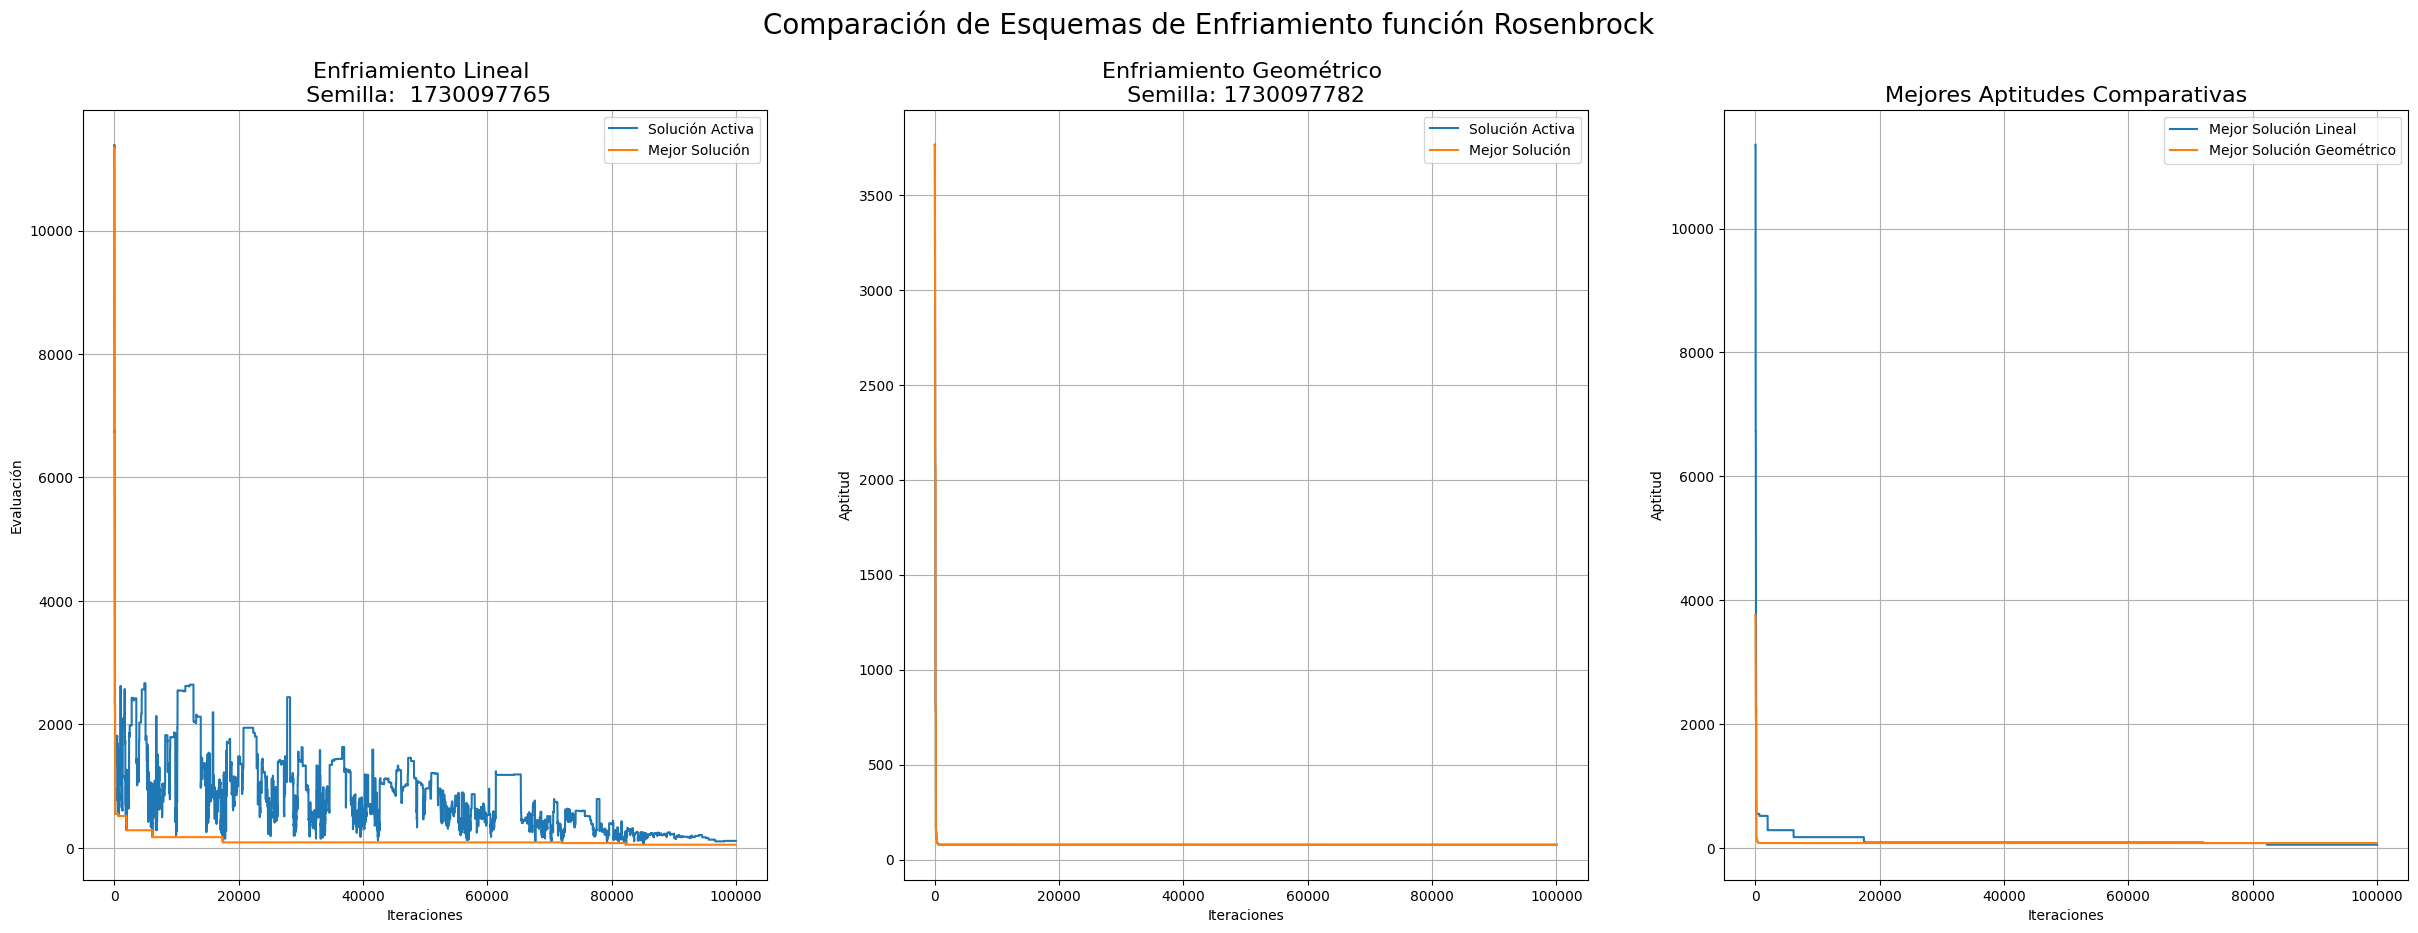

In [26]:

# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Rosenbrock', fontsize=20)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesRL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesRL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal \n Semilla:  1730097765', fontsize=16)
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesRG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesRG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico \n Semilla: 1730097782 ', fontsize=16)
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Aptitud')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesRL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesRG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas', fontsize=16)
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

### Ackley


In [27]:
# Ackley Lineal. Primera ejecución, Semilla: 1730097682
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Ackley, intervaloAckley, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal', 1730097682 )

# Ackley Geometrico. Primera ejecución, Semilla: 1730097702
mejores_soluciones_binariasAG, mejores_evaluacionesAG, activas_soluciones_binariasAG, activas_evaluacionesAG = Recocido_Simulado(Ackley, intervaloAckley, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico',1730097702 )


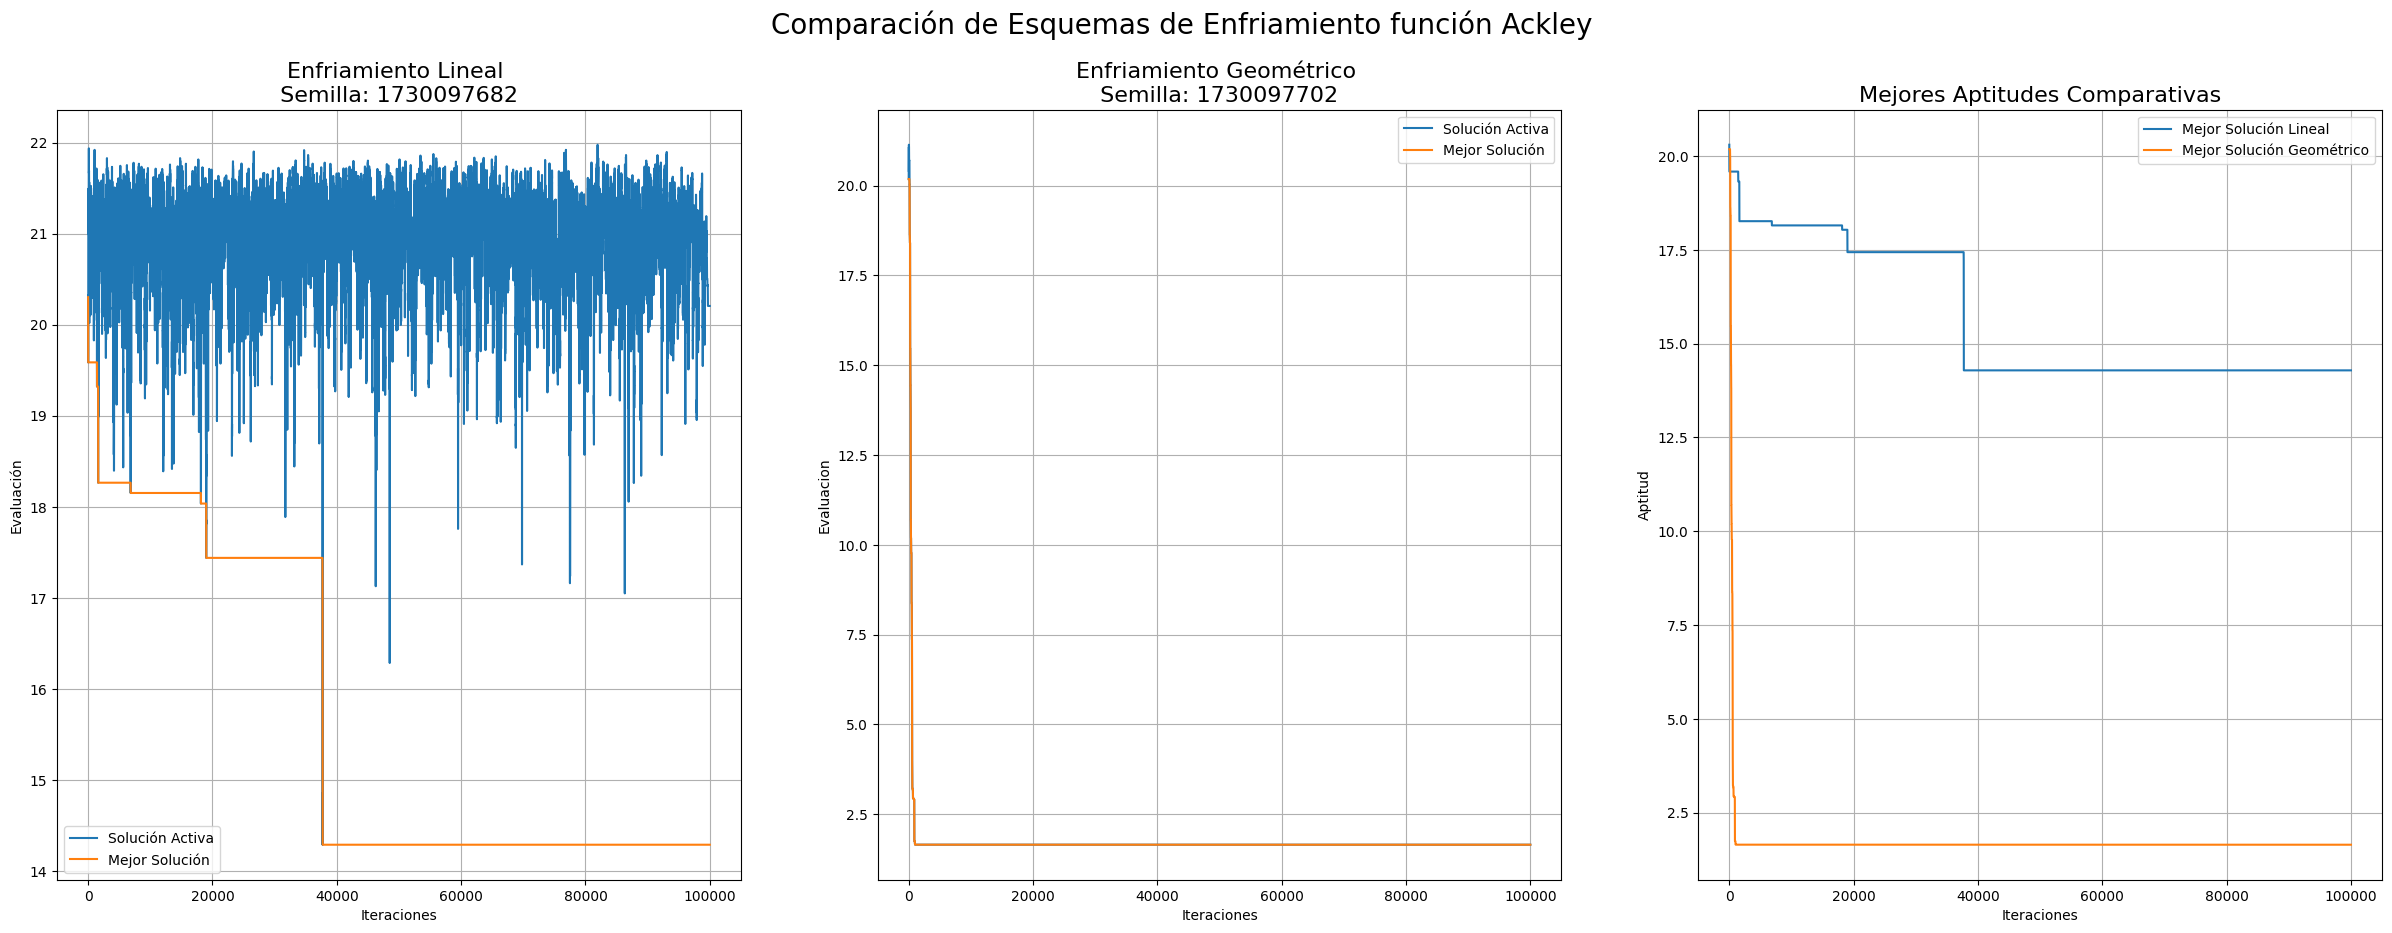

In [28]:
# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Ackley', fontsize=20)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesAL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesAL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal \n Semilla: 1730097682 ', fontsize=16)
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesAG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesAG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico \n Semilla: 1730097702 ', fontsize=16)
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Evaluacion')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesAL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesAG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas', fontsize=16)
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

### Sphere 

In [29]:
# Sphere Lineal. Primera ejecucion Semilla: 1730097836
mejores_soluciones_binariasSL, mejores_evaluacionesSL, activas_soluciones_binariasSL, activas_evaluacionesSL = Recocido_Simulado(Sphere, intervaloSphere, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal', 1730097836)

# Sphere Geometrico. Primera ejecucion  Semilla: 1730097853
mejores_soluciones_binariasSG, mejores_evaluacionesSG, activas_soluciones_binariasSG, activas_evaluacionesSG = Recocido_Simulado(Sphere, intervaloSphere, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico', 1730097853)


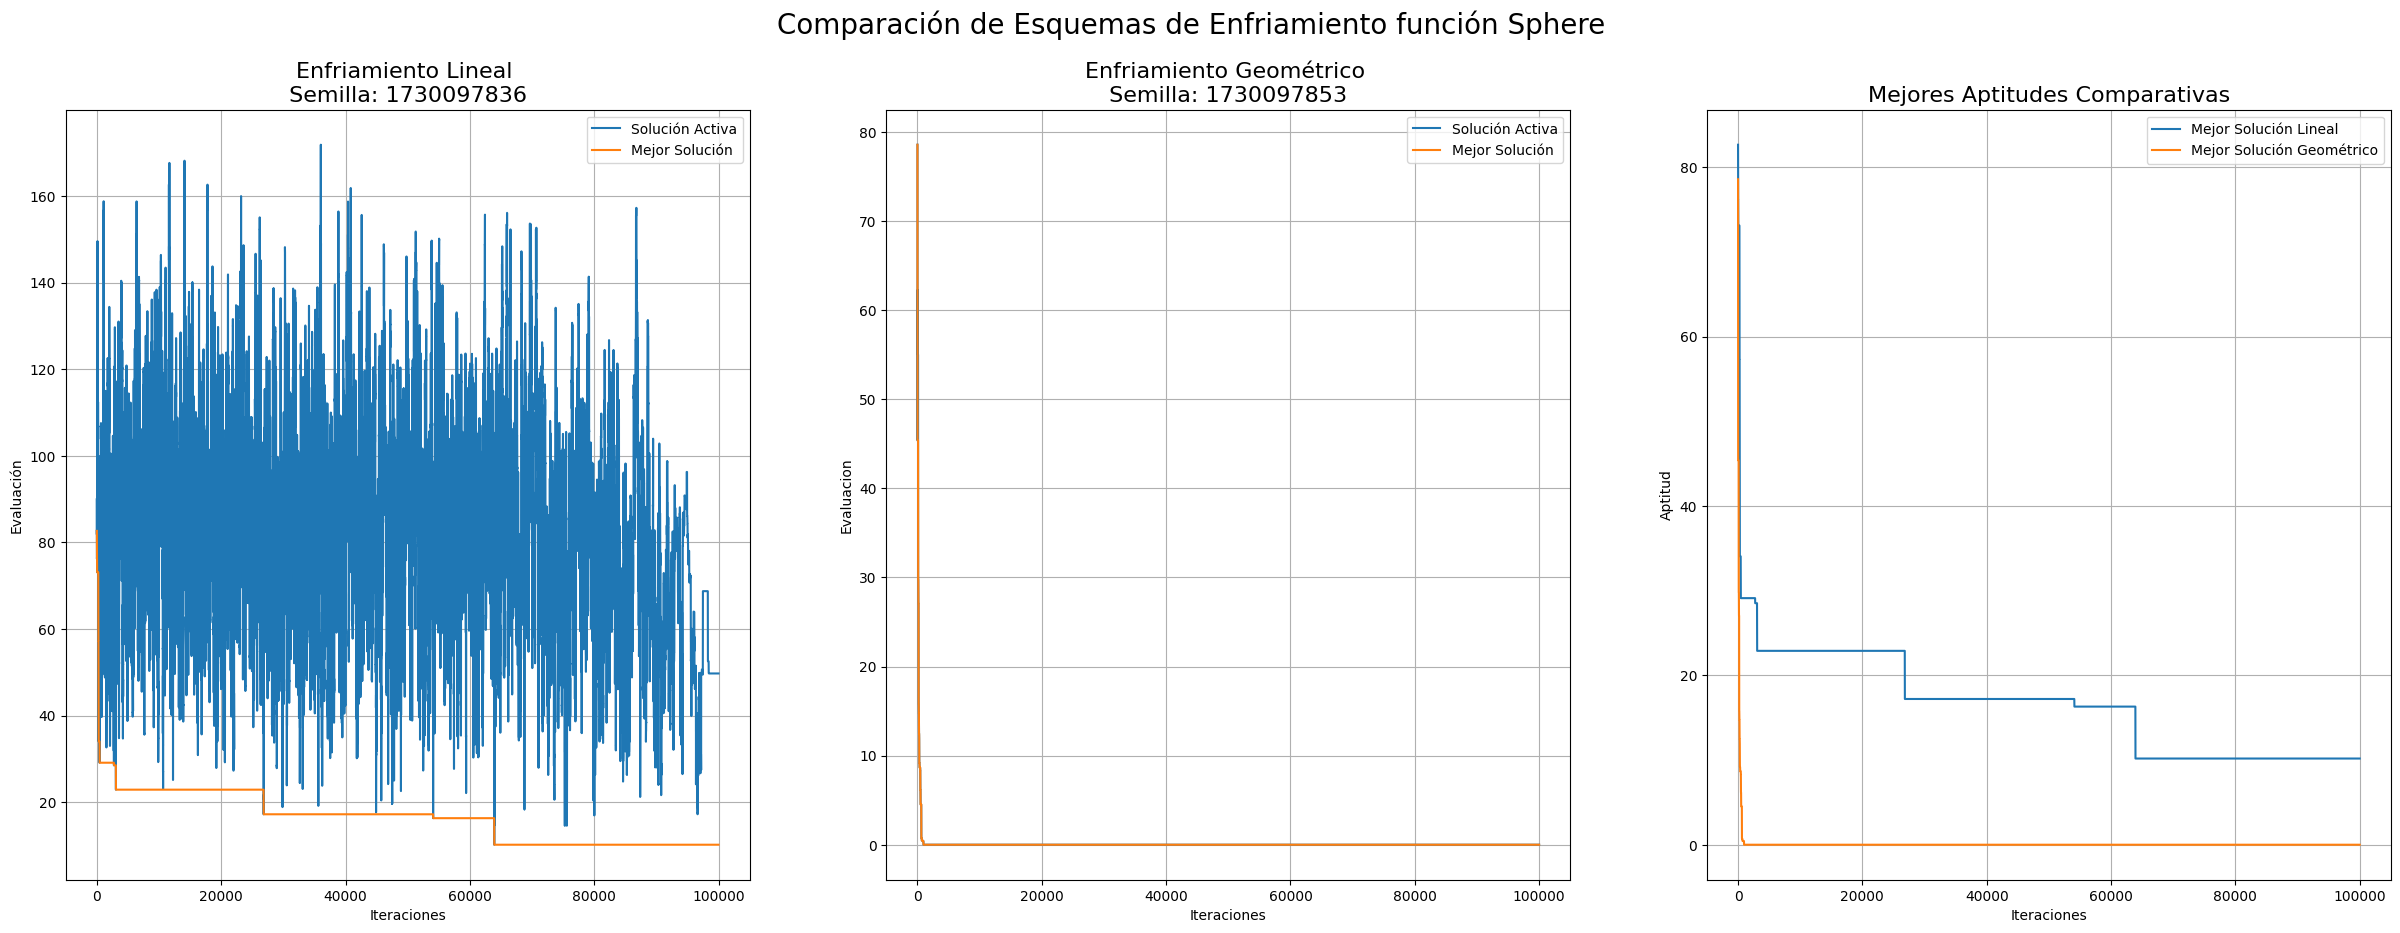

In [30]:
# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Sphere', fontsize=20)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesSL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesSL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal \n Semilla: 1730097836 ', fontsize=16)
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesSG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesSG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico \n Semilla: 1730097853 ', fontsize=16)
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Evaluacion')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesSL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesSG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas' , fontsize=16)
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

### Griewank 

In [34]:
# Griewank Lineal. Primera ejecución Semilla: 1730097722
mejores_soluciones_binariasGL, mejores_evaluacionesGL, activas_soluciones_binariasGL, activas_evaluacionesGL = Recocido_Simulado(Griewank, intervaloGriewank, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal', 1730097722)

# Griewank Geometrico. Primera ejecución  Semilla: 1730097744
mejores_soluciones_binariasGG, mejores_evaluacionesGG, activas_soluciones_binariasGG, activas_evaluacionesGG = Recocido_Simulado(Griewank, intervaloGriewank, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico', 1730097744)


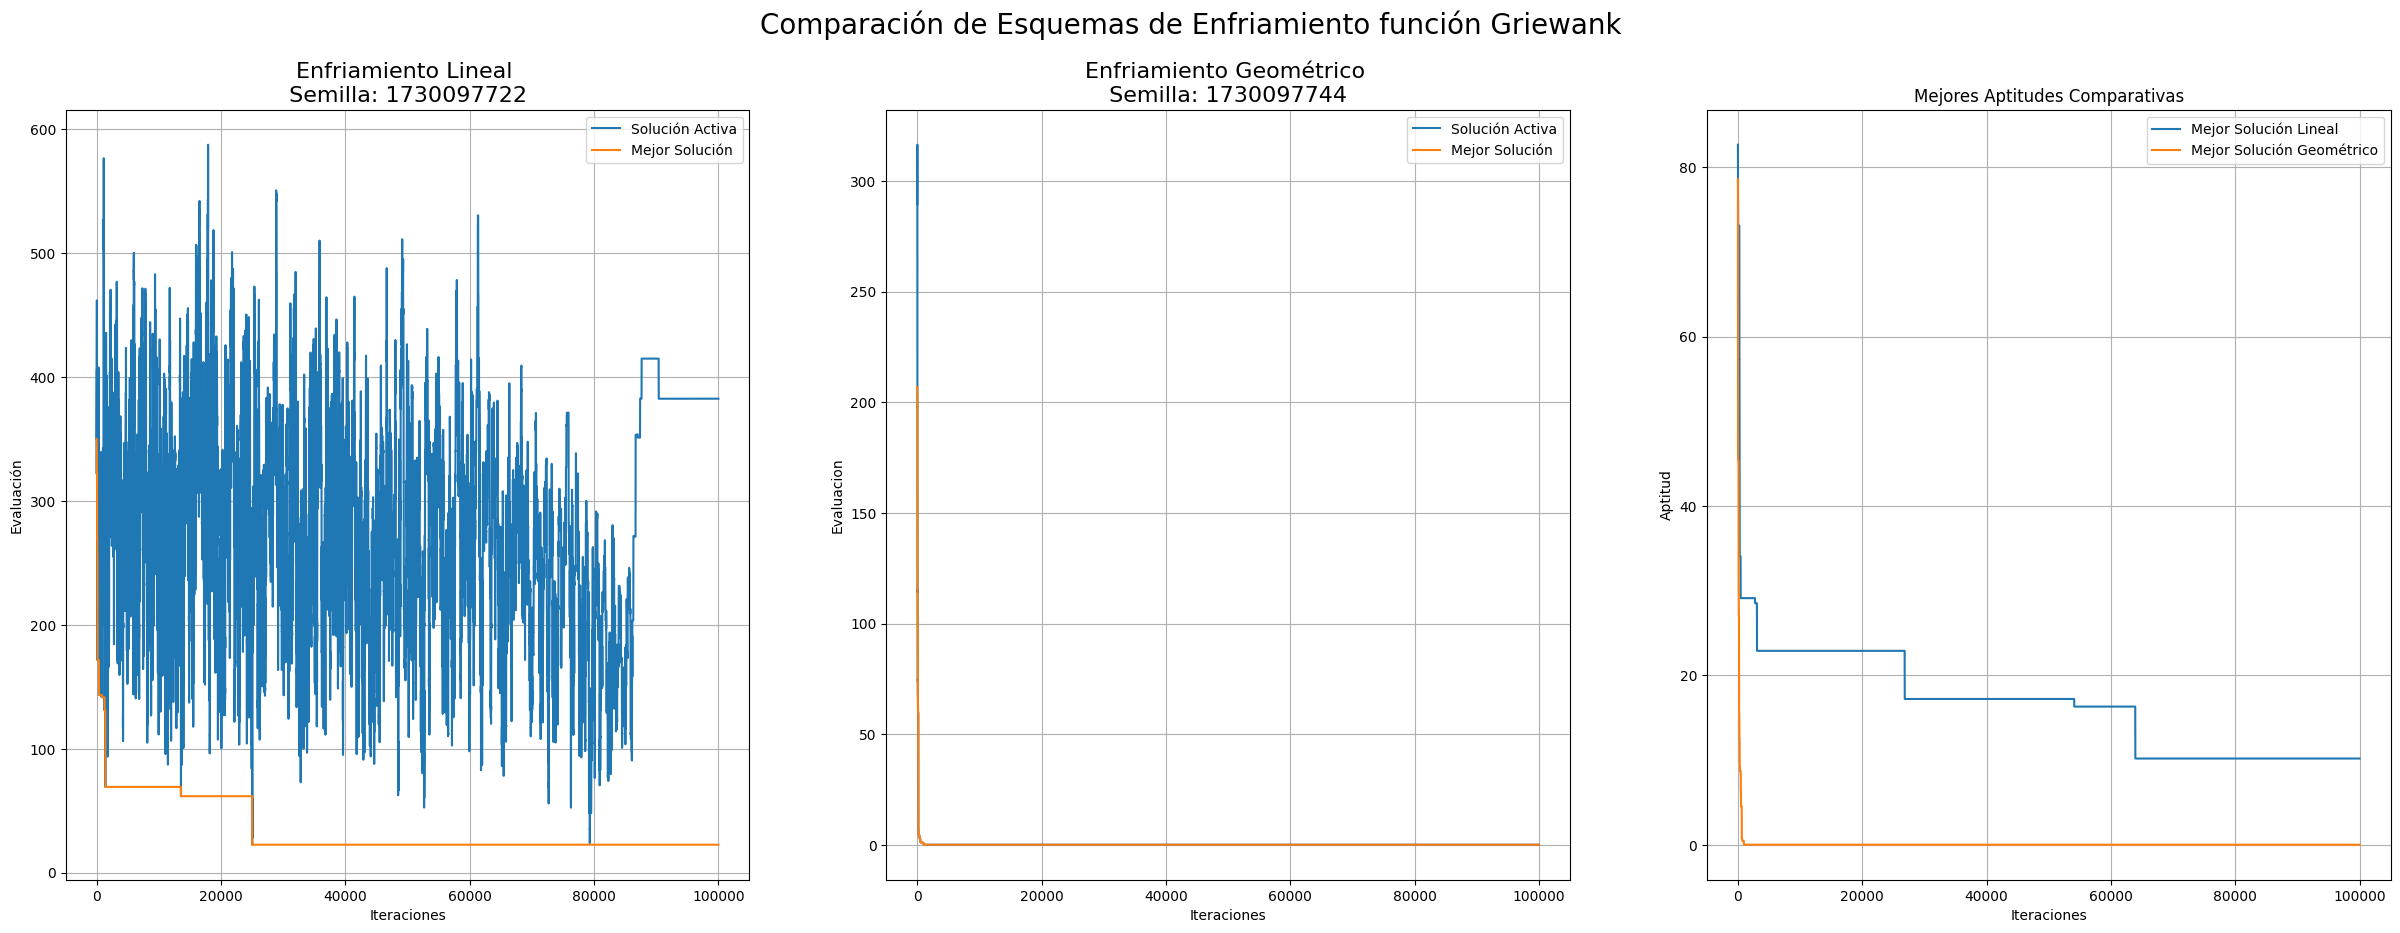

In [35]:
# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Griewank', fontsize=20)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesGL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesGL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal \n Semilla: 1730097722 ', fontsize=16)
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesGG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesGG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico \n Semilla: 1730097744 ', fontsize=16)
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Evaluacion')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesSL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesSG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas')
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

### Rastrigin 

In [36]:
# Rastrigin Lineal. Primera ejecucion Semilla: 1730097799
mejores_soluciones_binariasNL, mejores_evaluacionesNL, activas_soluciones_binariasNL, activas_evaluacionesNL = Recocido_Simulado(Rastrigin, intervaloRastrigin, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')

# Rastrigin Geometrico. Primera ejecucion Semilla: 1730097818
mejores_soluciones_binariasNG, mejores_evaluacionesNG, activas_soluciones_binariasNG, activas_evaluacionesNG = Recocido_Simulado(Rastrigin, intervaloRastrigin, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')
    

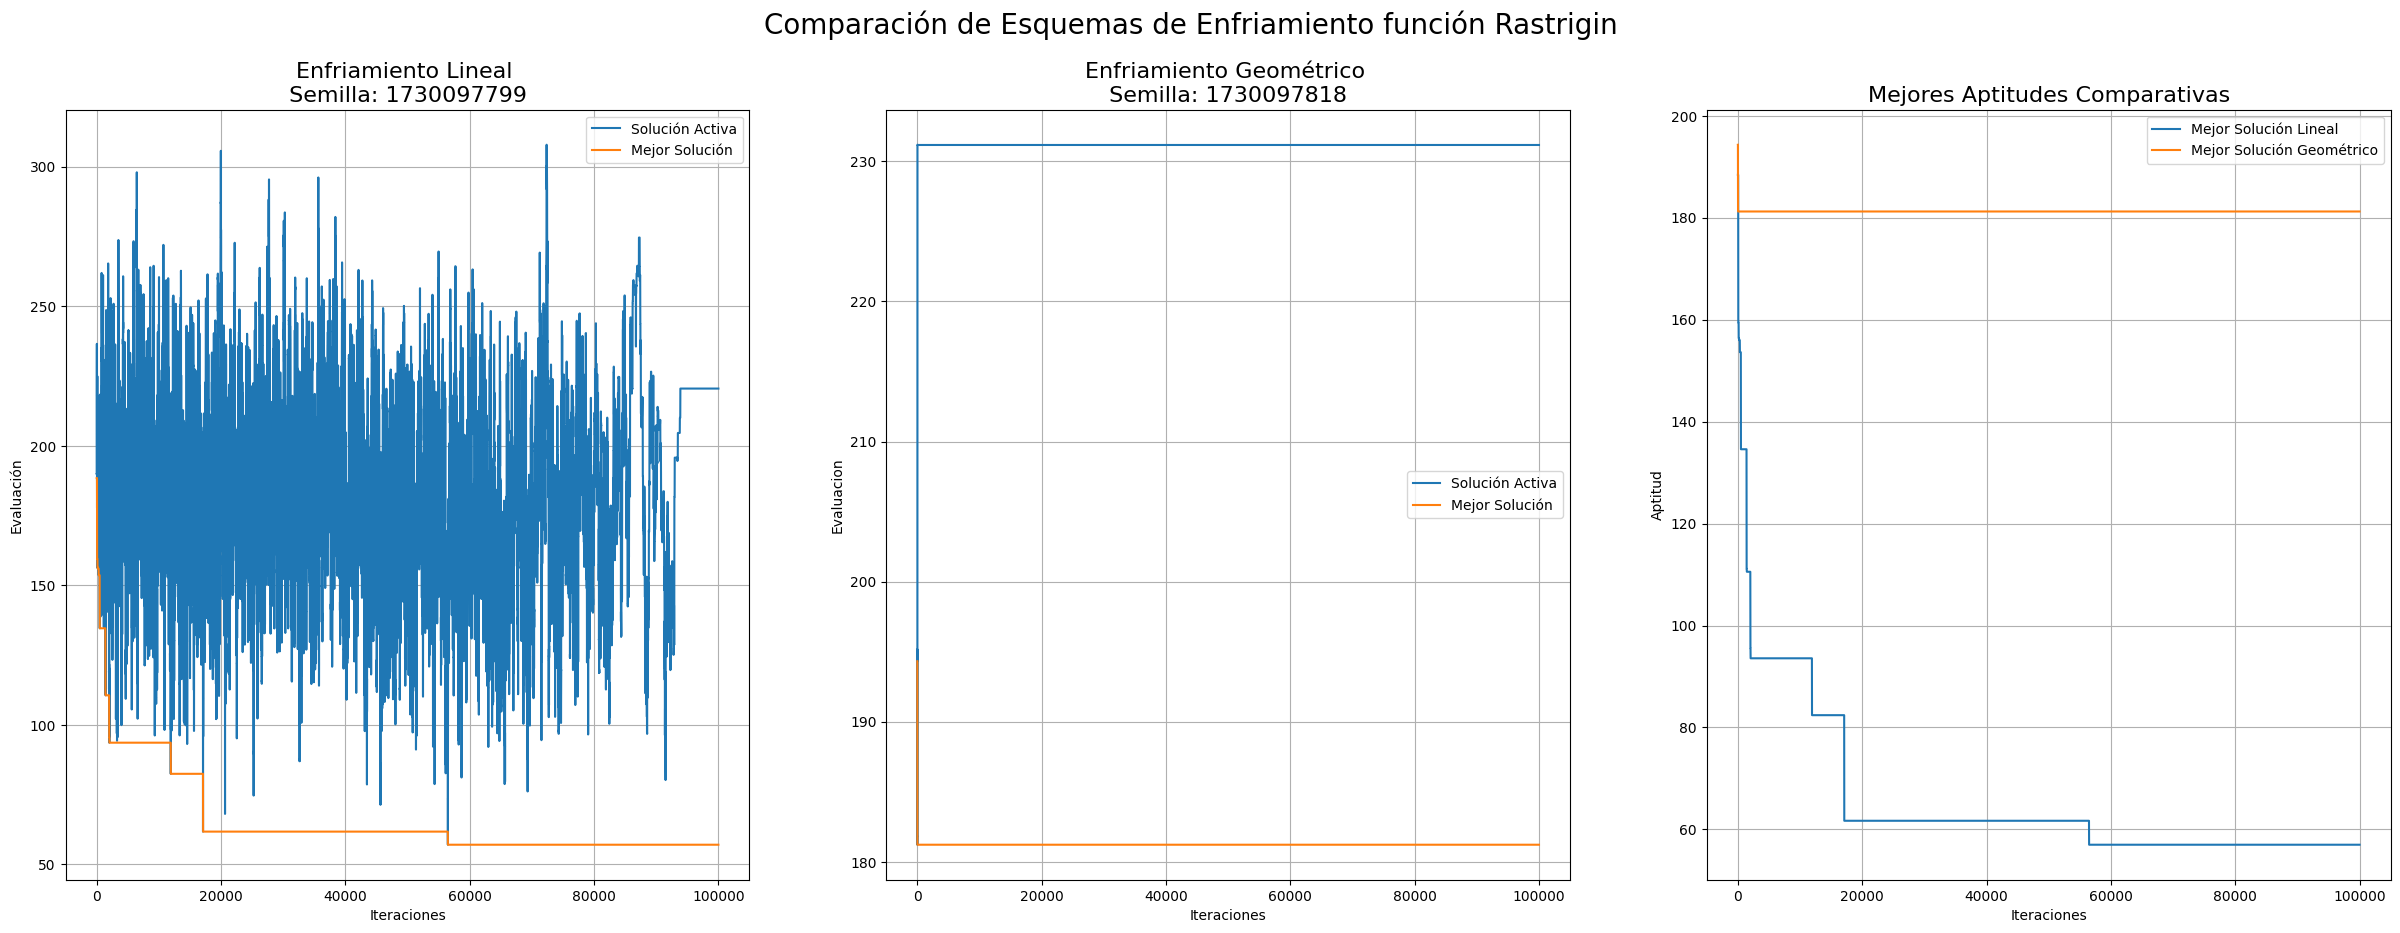

In [37]:
# Configuramos la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plt.suptitle('Comparación de Esquemas de Enfriamiento función Rastrigin', fontsize=20)

# Gráfica 1: Aptitudes promedio y mejores (Enfriamiento Lineal)
axs[0].plot(activas_evaluacionesNL, label='Solución Activa')
axs[0].plot(mejores_evaluacionesNL, label='Mejor Solución')
axs[0].set_title('Enfriamiento Lineal \n Semilla: 1730097799 ', fontsize=16)
axs[0].set_xlabel('Iteraciones')
axs[0].set_ylabel('Evaluación')
axs[0].legend()
axs[0].grid()

# Gráfica 2: Aptitudes promedio y mejores (Enfriamiento Geométrico)
axs[1].plot(activas_evaluacionesNG, label='Solución Activa')
axs[1].plot(mejores_evaluacionesNG, label='Mejor Solución')
axs[1].set_title('Enfriamiento Geométrico \n Semilla: 1730097818 ', fontsize=16)
axs[1].set_xlabel('Iteraciones')
axs[1].set_ylabel('Evaluacion')
axs[1].legend()
axs[1].grid()

# Gráfica 3: Mejores de esquema lineal y geométrico
axs[2].plot(mejores_evaluacionesNL, label='Mejor Solución Lineal')
axs[2].plot(mejores_evaluacionesNG, label='Mejor Solución Geométrico')
axs[2].set_title('Mejores Aptitudes Comparativas', fontsize=16)
axs[2].set_xlabel('Iteraciones')
axs[2].set_ylabel('Aptitud')
axs[2].legend()
axs[2].grid()

plt.show()

## Generar archivos CSV

## Ackley

### Ackley Lineal

In [22]:
import time
import numpy as np

# Función principal para ejecutar 30 veces
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Ackley geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Ackley, intervaloAckley, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Ackley_resultados_lineal_{j+1}.csv"

        # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()


### Ackley Geométrico

In [23]:
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Griewank geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Ackley, intervaloAckley, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Ackley_resultados_geometrico_{j+1}.csv"

        # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()

# Griewank

### Griewank lineal

In [24]:
# Función principal para ejecutar 30 veces
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Ackley geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Griewank, intervaloGriewank, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Griewank_resultados_lineal_{j+1}.csv"

           # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()


### Griewank geométrico

In [25]:
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Griewank geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Griewank, intervaloGriewank, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Griewank_resultados_geometrico_{j+1}.csv"

          # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()

## Rosenbrock

### Rosenbrock lineal

In [26]:
# Función principal para ejecutar 30 veces
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Ackley geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Rosenbrock, intervaloRosenbrock, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Rosenbrock_resultados_lineal_{j+1}.csv"

           # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()

### Rosenbrock geométrico

In [27]:
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Griewank geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Rosenbrock, intervaloRosenbrock, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Rosenbrock_resultados_geometrico_{j+1}.csv"

           # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()

## Rastrigin

### Rastrigin lineal

In [28]:
# Función principal para ejecutar 30 veces
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Ackley geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Rastrigin, intervaloRastrigin, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Rastrigin_resultados_lineal_{j+1}.csv"

           # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()

### Rastrigin geométrico

In [29]:
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Griewank geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Rastrigin, intervaloRastrigin, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Rastrigin_resultados_geometrico_{j+1}.csv"

           # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()

## Sphere

### Sphere lineal

In [30]:
# Función principal para ejecutar 30 veces
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Ackley geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Sphere, intervaloSphere, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Sphere_resultados_lineal_{j+1}.csv"

           # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()

### Sphere geométrico

In [31]:
def ejecutar_algoritmo_y_guardar_resultados(ejecuciones=30, iteraciones=100000):

    for j in range(ejecuciones):
        # Generar semilla única para cada ejecución
        seed = int(time.time()) % (2**32)
        seed += j
        np.random.seed(seed)

        # Griewank geometrico 
        mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Sphere, intervaloSphere, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')


        # Guardar resultados en un archivo CSV por cada ejecución
        nombre_archivo = f"Sphere_resultados_geometrico_{j+1}.csv"

          # Verificar el número de columnas en 'datos'
        datos = np.column_stack((mejores_evaluacionesAL, activas_evaluacionesAL))

        # Ajustar el número de %f en fmt según el número de columnas en datos
        num_columnas = datos.shape[1]  # Número de columnas en los datos
        fmt = ','.join(['%f'] * num_columnas)  # Crear un formato dinámico basado en el número de columnas

        # Guardar el archivo con el comentario y los datos
        with open(nombre_archivo, 'w') as f:
            # Escribir el comentario al inicio del archivo
            f.write(f"# Semilla: {seed}\n")
            # Escribir el encabezado
            f.write("MejorEval,SolActiva\n")
            # Guardar los datos
            np.savetxt(f, datos, delimiter=',', fmt=fmt)

 # Ejecutar el algoritmo y guardar resultados
ejecutar_algoritmo_y_guardar_resultados()

Vamos a leer los archivos que generamos

In [43]:
geometricoAckley1 = pd.read_csv("Ackley_resultados_geometrico_1.csv", comment='#')
geometricoAckley2 = pd.read_csv("Ackley_resultados_geometrico_2.csv", comment='#')
geometricoAckley3 = pd.read_csv("Ackley_resultados_geometrico_3.csv", comment='#')
geometricoAckley4 = pd.read_csv("Ackley_resultados_geometrico_4.csv", comment='#')
geometricoAckley5 = pd.read_csv("Ackley_resultados_geometrico_5.csv", comment='#')
geometricoAckley6 = pd.read_csv("Ackley_resultados_geometrico_6.csv", comment='#')
geometricoAckley7 = pd.read_csv("Ackley_resultados_geometrico_7.csv", comment='#')
geometricoAckley8 = pd.read_csv("Ackley_resultados_geometrico_8.csv", comment='#')
geometricoAckley9 = pd.read_csv("Ackley_resultados_geometrico_9.csv", comment='#')
geometricoAckley10 = pd.read_csv("Ackley_resultados_geometrico_10.csv", comment='#')
geometricoAckley11 = pd.read_csv("Ackley_resultados_geometrico_11.csv", comment='#')
geometricoAckley12 = pd.read_csv("Ackley_resultados_geometrico_12.csv", comment='#')
geometricoAckley13 = pd.read_csv("Ackley_resultados_geometrico_13.csv", comment='#')
geometricoAckley14 = pd.read_csv("Ackley_resultados_geometrico_14.csv", comment='#')
geometricoAckley15 = pd.read_csv("Ackley_resultados_geometrico_15.csv", comment='#')
geometricoAckley16 = pd.read_csv("Ackley_resultados_geometrico_16.csv", comment='#')
geometricoAckley17 = pd.read_csv("Ackley_resultados_geometrico_17.csv", comment='#')
geometricoAckley18 = pd.read_csv("Ackley_resultados_geometrico_18.csv", comment='#')
geometricoAckley19 = pd.read_csv("Ackley_resultados_geometrico_19.csv", comment='#')
geometricoAckley20 = pd.read_csv("Ackley_resultados_geometrico_20.csv", comment='#')
geometricoAckley21 = pd.read_csv("Ackley_resultados_geometrico_21.csv", comment='#')
geometricoAckley22 = pd.read_csv("Ackley_resultados_geometrico_22.csv", comment='#')
geometricoAckley23 = pd.read_csv("Ackley_resultados_geometrico_23.csv", comment='#')
geometricoAckley24 = pd.read_csv("Ackley_resultados_geometrico_24.csv", comment='#')
geometricoAckley25 = pd.read_csv("Ackley_resultados_geometrico_25.csv", comment='#')
geometricoAckley26 = pd.read_csv("Ackley_resultados_geometrico_26.csv", comment='#')
geometricoAckley27 = pd.read_csv("Ackley_resultados_geometrico_27.csv", comment='#')
geometricoAckley28 = pd.read_csv("Ackley_resultados_geometrico_28.csv", comment='#')
geometricoAckley29 = pd.read_csv("Ackley_resultados_geometrico_29.csv", comment='#')
geometricoAckley30 = pd.read_csv("Ackley_resultados_geometrico_30.csv", comment='#')

linealAckley1 = pd.read_csv("Ackley_resultados_lineal_1.csv", comment='#')
linealAckley2 = pd.read_csv("Ackley_resultados_lineal_2.csv", comment='#')
linealAckley3 = pd.read_csv("Ackley_resultados_lineal_3.csv", comment='#')
linealAckley4 = pd.read_csv("Ackley_resultados_lineal_4.csv", comment='#')
linealAckley5 = pd.read_csv("Ackley_resultados_lineal_5.csv", comment='#')
linealAckley6 = pd.read_csv("Ackley_resultados_lineal_6.csv", comment='#')
linealAckley7 = pd.read_csv("Ackley_resultados_lineal_7.csv", comment='#')
linealAckley8 = pd.read_csv("Ackley_resultados_lineal_8.csv", comment='#')
linealAckley9 = pd.read_csv("Ackley_resultados_lineal_9.csv", comment='#')
linealAckley10 = pd.read_csv("Ackley_resultados_lineal_10.csv", comment='#')
linealAckley11 = pd.read_csv("Ackley_resultados_lineal_11.csv", comment='#')
linealAckley12 = pd.read_csv("Ackley_resultados_lineal_12.csv", comment='#')
linealAckley13 = pd.read_csv("Ackley_resultados_lineal_13.csv", comment='#')
linealAckley14 = pd.read_csv("Ackley_resultados_lineal_14.csv", comment='#')
linealAckley15 = pd.read_csv("Ackley_resultados_lineal_15.csv", comment='#')
linealAckley16 = pd.read_csv("Ackley_resultados_lineal_16.csv", comment='#')
linealAckley17 = pd.read_csv("Ackley_resultados_lineal_17.csv", comment='#')
linealAckley18 = pd.read_csv("Ackley_resultados_lineal_18.csv", comment='#')
linealAckley19 = pd.read_csv("Ackley_resultados_lineal_19.csv", comment='#')
linealAckley20 = pd.read_csv("Ackley_resultados_lineal_20.csv", comment='#')
linealAckley21 = pd.read_csv("Ackley_resultados_lineal_21.csv", comment='#')
linealAckley22 = pd.read_csv("Ackley_resultados_lineal_22.csv", comment='#')
linealAckley23 = pd.read_csv("Ackley_resultados_lineal_23.csv", comment='#')
linealAckley24 = pd.read_csv("Ackley_resultados_lineal_24.csv", comment='#')
linealAckley25 = pd.read_csv("Ackley_resultados_lineal_25.csv", comment='#')
linealAckley26 = pd.read_csv("Ackley_resultados_lineal_26.csv", comment='#')
linealAckley27 = pd.read_csv("Ackley_resultados_lineal_27.csv", comment='#')
linealAckley28 = pd.read_csv("Ackley_resultados_lineal_28.csv", comment='#')
linealAckley29 = pd.read_csv("Ackley_resultados_lineal_29.csv", comment='#')
linealAckley30 = pd.read_csv("Ackley_resultados_lineal_30.csv", comment='#')



In [44]:
geometricoGriewank1 = pd.read_csv("Griewank_resultados_geometrico_1.csv", comment='#')
geometricoGriewank2 = pd.read_csv("Griewank_resultados_geometrico_2.csv", comment='#')
geometricoGriewank3 = pd.read_csv("Griewank_resultados_geometrico_3.csv", comment='#')
geometricoGriewank4 = pd.read_csv("Griewank_resultados_geometrico_4.csv", comment='#')
geometricoGriewank5 = pd.read_csv("Griewank_resultados_geometrico_5.csv", comment='#')
geometricoGriewank6 = pd.read_csv("Griewank_resultados_geometrico_6.csv", comment='#')
geometricoGriewank7 = pd.read_csv("Griewank_resultados_geometrico_7.csv", comment='#')
geometricoGriewank8 = pd.read_csv("Griewank_resultados_geometrico_8.csv", comment='#')
geometricoGriewank9 = pd.read_csv("Griewank_resultados_geometrico_9.csv", comment='#')
geometricoGriewank10 = pd.read_csv("Griewank_resultados_geometrico_10.csv", comment='#')
geometricoGriewank11 = pd.read_csv("Griewank_resultados_geometrico_11.csv", comment='#')
geometricoGriewank12 = pd.read_csv("Griewank_resultados_geometrico_12.csv", comment='#')
geometricoGriewank13 = pd.read_csv("Griewank_resultados_geometrico_13.csv", comment='#')
geometricoGriewank14 = pd.read_csv("Griewank_resultados_geometrico_14.csv", comment='#')
geometricoGriewank15 = pd.read_csv("Griewank_resultados_geometrico_15.csv", comment='#')
geometricoGriewank16 = pd.read_csv("Griewank_resultados_geometrico_16.csv", comment='#')
geometricoGriewank17 = pd.read_csv("Griewank_resultados_geometrico_17.csv", comment='#')
geometricoGriewank18 = pd.read_csv("Griewank_resultados_geometrico_18.csv", comment='#')
geometricoGriewank19 = pd.read_csv("Griewank_resultados_geometrico_19.csv", comment='#')
geometricoGriewank20 = pd.read_csv("Griewank_resultados_geometrico_20.csv", comment='#')
geometricoGriewank21 = pd.read_csv("Griewank_resultados_geometrico_21.csv", comment='#')
geometricoGriewank22 = pd.read_csv("Griewank_resultados_geometrico_22.csv", comment='#')
geometricoGriewank23 = pd.read_csv("Griewank_resultados_geometrico_23.csv", comment='#')
geometricoGriewank24 = pd.read_csv("Griewank_resultados_geometrico_24.csv", comment='#')
geometricoGriewank25 = pd.read_csv("Griewank_resultados_geometrico_25.csv", comment='#')
geometricoGriewank26 = pd.read_csv("Griewank_resultados_geometrico_26.csv", comment='#')
geometricoGriewank27 = pd.read_csv("Griewank_resultados_geometrico_27.csv", comment='#')
geometricoGriewank28 = pd.read_csv("Griewank_resultados_geometrico_28.csv", comment='#')
geometricoGriewank29 = pd.read_csv("Griewank_resultados_geometrico_29.csv", comment='#')
geometricoGriewank30 = pd.read_csv("Griewank_resultados_geometrico_30.csv", comment='#')

linealGriewank1 = pd.read_csv("Griewank_resultados_lineal_1.csv", comment='#')
linealGriewank2 = pd.read_csv("Griewank_resultados_lineal_2.csv", comment='#')
linealGriewank3 = pd.read_csv("Griewank_resultados_lineal_3.csv", comment='#')
linealGriewank4 = pd.read_csv("Griewank_resultados_lineal_4.csv", comment='#')
linealGriewank5 = pd.read_csv("Griewank_resultados_lineal_5.csv", comment='#')
linealGriewank6 = pd.read_csv("Griewank_resultados_lineal_6.csv", comment='#')
linealGriewank7 = pd.read_csv("Griewank_resultados_lineal_7.csv", comment='#')
linealGriewank8 = pd.read_csv("Griewank_resultados_lineal_8.csv", comment='#')
linealGriewank9 = pd.read_csv("Griewank_resultados_lineal_9.csv", comment='#')
linealGriewank10 = pd.read_csv("Griewank_resultados_lineal_10.csv", comment='#')
linealGriewank11 = pd.read_csv("Griewank_resultados_lineal_11.csv", comment='#')
linealGriewank12 = pd.read_csv("Griewank_resultados_lineal_12.csv", comment='#')
linealGriewank13 = pd.read_csv("Griewank_resultados_lineal_13.csv", comment='#')
linealGriewank14 = pd.read_csv("Griewank_resultados_lineal_14.csv", comment='#')
linealGriewank15 = pd.read_csv("Griewank_resultados_lineal_15.csv", comment='#')
linealGriewank16 = pd.read_csv("Griewank_resultados_lineal_16.csv", comment='#')
linealGriewank17 = pd.read_csv("Griewank_resultados_lineal_17.csv", comment='#')
linealGriewank18 = pd.read_csv("Griewank_resultados_lineal_18.csv", comment='#')
linealGriewank19 = pd.read_csv("Griewank_resultados_lineal_19.csv", comment='#')
linealGriewank20 = pd.read_csv("Griewank_resultados_lineal_20.csv", comment='#')
linealGriewank21 = pd.read_csv("Griewank_resultados_lineal_21.csv", comment='#')
linealGriewank22 = pd.read_csv("Griewank_resultados_lineal_22.csv", comment='#')
linealGriewank23 = pd.read_csv("Griewank_resultados_lineal_23.csv", comment='#')
linealGriewank24 = pd.read_csv("Griewank_resultados_lineal_24.csv", comment='#')
linealGriewank25 = pd.read_csv("Griewank_resultados_lineal_25.csv", comment='#')
linealGriewank26 = pd.read_csv("Griewank_resultados_lineal_26.csv", comment='#')
linealGriewank27 = pd.read_csv("Griewank_resultados_lineal_27.csv", comment='#')
linealGriewank28 = pd.read_csv("Griewank_resultados_lineal_28.csv", comment='#')
linealGriewank29 = pd.read_csv("Griewank_resultados_lineal_29.csv", comment='#')
linealGriewank30 = pd.read_csv("Griewank_resultados_lineal_30.csv", comment='#')

In [45]:
geometricoRosenbrock1 = pd.read_csv("Rosenbrock_resultados_geometrico_1.csv", comment='#')
geometricoRosenbrock2 = pd.read_csv("Rosenbrock_resultados_geometrico_2.csv", comment='#')
geometricoRosenbrock3 = pd.read_csv("Rosenbrock_resultados_geometrico_3.csv", comment='#')
geometricoRosenbrock4 = pd.read_csv("Rosenbrock_resultados_geometrico_4.csv", comment='#')
geometricoRosenbrock5 = pd.read_csv("Rosenbrock_resultados_geometrico_5.csv", comment='#')
geometricoRosenbrock6 = pd.read_csv("Rosenbrock_resultados_geometrico_6.csv", comment='#')
geometricoRosenbrock7 = pd.read_csv("Rosenbrock_resultados_geometrico_7.csv", comment='#')
geometricoRosenbrock8 = pd.read_csv("Rosenbrock_resultados_geometrico_8.csv", comment='#')
geometricoRosenbrock9 = pd.read_csv("Rosenbrock_resultados_geometrico_9.csv", comment='#')
geometricoRosenbrock10 = pd.read_csv("Rosenbrock_resultados_geometrico_10.csv", comment='#')
geometricoRosenbrock11 = pd.read_csv("Rosenbrock_resultados_geometrico_11.csv", comment='#')
geometricoRosenbrock12 = pd.read_csv("Rosenbrock_resultados_geometrico_12.csv", comment='#')
geometricoRosenbrock13 = pd.read_csv("Rosenbrock_resultados_geometrico_13.csv", comment='#')
geometricoRosenbrock14 = pd.read_csv("Rosenbrock_resultados_geometrico_14.csv", comment='#')
geometricoRosenbrock15 = pd.read_csv("Rosenbrock_resultados_geometrico_15.csv", comment='#')
geometricoRosenbrock16 = pd.read_csv("Rosenbrock_resultados_geometrico_16.csv", comment='#')
geometricoRosenbrock17 = pd.read_csv("Rosenbrock_resultados_geometrico_17.csv", comment='#')
geometricoRosenbrock18 = pd.read_csv("Rosenbrock_resultados_geometrico_18.csv", comment='#')
geometricoRosenbrock19 = pd.read_csv("Rosenbrock_resultados_geometrico_19.csv", comment='#')
geometricoRosenbrock20 = pd.read_csv("Rosenbrock_resultados_geometrico_20.csv", comment='#')
geometricoRosenbrock21 = pd.read_csv("Rosenbrock_resultados_geometrico_21.csv", comment='#')
geometricoRosenbrock22 = pd.read_csv("Rosenbrock_resultados_geometrico_22.csv", comment='#')
geometricoRosenbrock23 = pd.read_csv("Rosenbrock_resultados_geometrico_23.csv", comment='#')
geometricoRosenbrock24 = pd.read_csv("Rosenbrock_resultados_geometrico_24.csv", comment='#')
geometricoRosenbrock25 = pd.read_csv("Rosenbrock_resultados_geometrico_25.csv", comment='#')
geometricoRosenbrock26 = pd.read_csv("Rosenbrock_resultados_geometrico_26.csv", comment='#')
geometricoRosenbrock27 = pd.read_csv("Rosenbrock_resultados_geometrico_27.csv", comment='#')
geometricoRosenbrock28 = pd.read_csv("Rosenbrock_resultados_geometrico_28.csv", comment='#')
geometricoRosenbrock29 = pd.read_csv("Rosenbrock_resultados_geometrico_29.csv", comment='#')
geometricoRosenbrock30 = pd.read_csv("Rosenbrock_resultados_geometrico_30.csv", comment='#')

linealRosenbrock1 = pd.read_csv("Rosenbrock_resultados_lineal_1.csv", comment='#')
linealRosenbrock2 = pd.read_csv("Rosenbrock_resultados_lineal_2.csv", comment='#')
linealRosenbrock3 = pd.read_csv("Rosenbrock_resultados_lineal_3.csv", comment='#')
linealRosenbrock4 = pd.read_csv("Rosenbrock_resultados_lineal_4.csv", comment='#')
linealRosenbrock5 = pd.read_csv("Rosenbrock_resultados_lineal_5.csv", comment='#')
linealRosenbrock6 = pd.read_csv("Rosenbrock_resultados_lineal_6.csv", comment='#')
linealRosenbrock7 = pd.read_csv("Rosenbrock_resultados_lineal_7.csv", comment='#')
linealRosenbrock8 = pd.read_csv("Rosenbrock_resultados_lineal_8.csv", comment='#')
linealRosenbrock9 = pd.read_csv("Rosenbrock_resultados_lineal_9.csv", comment='#')
linealRosenbrock10 = pd.read_csv("Rosenbrock_resultados_lineal_10.csv", comment='#')
linealRosenbrock11 = pd.read_csv("Rosenbrock_resultados_lineal_11.csv", comment='#')
linealRosenbrock12 = pd.read_csv("Rosenbrock_resultados_lineal_12.csv", comment='#')
linealRosenbrock13 = pd.read_csv("Rosenbrock_resultados_lineal_13.csv", comment='#')
linealRosenbrock14 = pd.read_csv("Rosenbrock_resultados_lineal_14.csv", comment='#')
linealRosenbrock15 = pd.read_csv("Rosenbrock_resultados_lineal_15.csv", comment='#')
linealRosenbrock16 = pd.read_csv("Rosenbrock_resultados_lineal_16.csv", comment='#')
linealRosenbrock17 = pd.read_csv("Rosenbrock_resultados_lineal_17.csv", comment='#')
linealRosenbrock18 = pd.read_csv("Rosenbrock_resultados_lineal_18.csv", comment='#')
linealRosenbrock19 = pd.read_csv("Rosenbrock_resultados_lineal_19.csv", comment='#')
linealRosenbrock20 = pd.read_csv("Rosenbrock_resultados_lineal_20.csv", comment='#')
linealRosenbrock21 = pd.read_csv("Rosenbrock_resultados_lineal_21.csv", comment='#')
linealRosenbrock22 = pd.read_csv("Rosenbrock_resultados_lineal_22.csv", comment='#')
linealRosenbrock23 = pd.read_csv("Rosenbrock_resultados_lineal_23.csv", comment='#')
linealRosenbrock24 = pd.read_csv("Rosenbrock_resultados_lineal_24.csv", comment='#')
linealRosenbrock25 = pd.read_csv("Rosenbrock_resultados_lineal_25.csv", comment='#')
linealRosenbrock26 = pd.read_csv("Rosenbrock_resultados_lineal_26.csv", comment='#')
linealRosenbrock27 = pd.read_csv("Rosenbrock_resultados_lineal_27.csv", comment='#')
linealRosenbrock28 = pd.read_csv("Rosenbrock_resultados_lineal_28.csv", comment='#')
linealRosenbrock29 = pd.read_csv("Rosenbrock_resultados_lineal_29.csv", comment='#')
linealRosenbrock30 = pd.read_csv("Rosenbrock_resultados_lineal_30.csv", comment='#')

In [46]:
geometricoRastrigin1 = pd.read_csv("Rastrigin_resultados_geometrico_1.csv", comment='#')
geometricoRastrigin2 = pd.read_csv("Rastrigin_resultados_geometrico_2.csv", comment='#')
geometricoRastrigin3 = pd.read_csv("Rastrigin_resultados_geometrico_3.csv", comment='#')
geometricoRastrigin4 = pd.read_csv("Rastrigin_resultados_geometrico_4.csv", comment='#')
geometricoRastrigin5 = pd.read_csv("Rastrigin_resultados_geometrico_5.csv", comment='#')
geometricoRastrigin6 = pd.read_csv("Rastrigin_resultados_geometrico_6.csv", comment='#')
geometricoRastrigin7 = pd.read_csv("Rastrigin_resultados_geometrico_7.csv", comment='#')
geometricoRastrigin8 = pd.read_csv("Rastrigin_resultados_geometrico_8.csv", comment='#')
geometricoRastrigin9 = pd.read_csv("Rastrigin_resultados_geometrico_9.csv", comment='#')
geometricoRastrigin10 = pd.read_csv("Rastrigin_resultados_geometrico_10.csv", comment='#')
geometricoRastrigin11 = pd.read_csv("Rastrigin_resultados_geometrico_11.csv", comment='#')
geometricoRastrigin12 = pd.read_csv("Rastrigin_resultados_geometrico_12.csv", comment='#')
geometricoRastrigin13 = pd.read_csv("Rastrigin_resultados_geometrico_13.csv", comment='#')
geometricoRastrigin14 = pd.read_csv("Rastrigin_resultados_geometrico_14.csv", comment='#')
geometricoRastrigin15 = pd.read_csv("Rastrigin_resultados_geometrico_15.csv", comment='#')
geometricoRastrigin16 = pd.read_csv("Rastrigin_resultados_geometrico_16.csv", comment='#')
geometricoRastrigin17 = pd.read_csv("Rastrigin_resultados_geometrico_17.csv", comment='#')
geometricoRastrigin18 = pd.read_csv("Rastrigin_resultados_geometrico_18.csv", comment='#')
geometricoRastrigin19 = pd.read_csv("Rastrigin_resultados_geometrico_19.csv", comment='#')
geometricoRastrigin20 = pd.read_csv("Rastrigin_resultados_geometrico_20.csv", comment='#')
geometricoRastrigin21 = pd.read_csv("Rastrigin_resultados_geometrico_21.csv", comment='#')
geometricoRastrigin22 = pd.read_csv("Rastrigin_resultados_geometrico_22.csv", comment='#')
geometricoRastrigin23 = pd.read_csv("Rastrigin_resultados_geometrico_23.csv", comment='#')
geometricoRastrigin24 = pd.read_csv("Rastrigin_resultados_geometrico_24.csv", comment='#')
geometricoRastrigin25 = pd.read_csv("Rastrigin_resultados_geometrico_25.csv", comment='#')
geometricoRastrigin26 = pd.read_csv("Rastrigin_resultados_geometrico_26.csv", comment='#')
geometricoRastrigin27 = pd.read_csv("Rastrigin_resultados_geometrico_27.csv", comment='#')
geometricoRastrigin28 = pd.read_csv("Rastrigin_resultados_geometrico_28.csv", comment='#')
geometricoRastrigin29 = pd.read_csv("Rastrigin_resultados_geometrico_29.csv", comment='#')
geometricoRastrigin30 = pd.read_csv("Rastrigin_resultados_geometrico_30.csv", comment='#')

linealRastrigin1 = pd.read_csv("Rastrigin_resultados_lineal_1.csv", comment='#')
linealRastrigin2 = pd.read_csv("Rastrigin_resultados_lineal_2.csv", comment='#')
linealRastrigin3 = pd.read_csv("Rastrigin_resultados_lineal_3.csv", comment='#')
linealRastrigin4 = pd.read_csv("Rastrigin_resultados_lineal_4.csv", comment='#')
linealRastrigin5 = pd.read_csv("Rastrigin_resultados_lineal_5.csv", comment='#')
linealRastrigin6 = pd.read_csv("Rastrigin_resultados_lineal_6.csv", comment='#')
linealRastrigin7 = pd.read_csv("Rastrigin_resultados_lineal_7.csv", comment='#')
linealRastrigin8 = pd.read_csv("Rastrigin_resultados_lineal_8.csv", comment='#')
linealRastrigin9 = pd.read_csv("Rastrigin_resultados_lineal_9.csv", comment='#')
linealRastrigin10 = pd.read_csv("Rastrigin_resultados_lineal_10.csv", comment='#')
linealRastrigin11 = pd.read_csv("Rastrigin_resultados_lineal_11.csv", comment='#')
linealRastrigin12 = pd.read_csv("Rastrigin_resultados_lineal_12.csv", comment='#')
linealRastrigin13 = pd.read_csv("Rastrigin_resultados_lineal_13.csv", comment='#')
linealRastrigin14 = pd.read_csv("Rastrigin_resultados_lineal_14.csv", comment='#')
linealRastrigin15 = pd.read_csv("Rastrigin_resultados_lineal_15.csv", comment='#')
linealRastrigin16 = pd.read_csv("Rastrigin_resultados_lineal_16.csv", comment='#')
linealRastrigin17 = pd.read_csv("Rastrigin_resultados_lineal_17.csv", comment='#')
linealRastrigin18 = pd.read_csv("Rastrigin_resultados_lineal_18.csv", comment='#')
linealRastrigin19 = pd.read_csv("Rastrigin_resultados_lineal_19.csv", comment='#')
linealRastrigin20 = pd.read_csv("Rastrigin_resultados_lineal_20.csv", comment='#')
linealRastrigin21 = pd.read_csv("Rastrigin_resultados_lineal_21.csv", comment='#')
linealRastrigin22 = pd.read_csv("Rastrigin_resultados_lineal_22.csv", comment='#')
linealRastrigin23 = pd.read_csv("Rastrigin_resultados_lineal_23.csv", comment='#')
linealRastrigin24 = pd.read_csv("Rastrigin_resultados_lineal_24.csv", comment='#')
linealRastrigin25 = pd.read_csv("Rastrigin_resultados_lineal_25.csv", comment='#')
linealRastrigin26 = pd.read_csv("Rastrigin_resultados_lineal_26.csv", comment='#')
linealRastrigin27 = pd.read_csv("Rastrigin_resultados_lineal_27.csv", comment='#')
linealRastrigin28 = pd.read_csv("Rastrigin_resultados_lineal_28.csv", comment='#')
linealRastrigin29 = pd.read_csv("Rastrigin_resultados_lineal_29.csv", comment='#')
linealRastrigin30 = pd.read_csv("Rastrigin_resultados_lineal_30.csv", comment='#')

In [56]:
geometricoSphere1 = pd.read_csv("Sphere_resultados_geometrico_1.csv", comment='#')
geometricoSphere2 = pd.read_csv("Sphere_resultados_geometrico_2.csv", comment='#')
geometricoSphere3 = pd.read_csv("Sphere_resultados_geometrico_3.csv", comment='#')
geometricoSphere4 = pd.read_csv("Sphere_resultados_geometrico_4.csv", comment='#')
geometricoSphere5 = pd.read_csv("Sphere_resultados_geometrico_5.csv", comment='#')
geometricoSphere6 = pd.read_csv("Sphere_resultados_geometrico_6.csv", comment='#')
geometricoSphere7 = pd.read_csv("Sphere_resultados_geometrico_7.csv", comment='#')
geometricoSphere8 = pd.read_csv("Sphere_resultados_geometrico_8.csv", comment='#')
geometricoSphere9 = pd.read_csv("Sphere_resultados_geometrico_9.csv", comment='#')
geometricoSphere10 = pd.read_csv("Sphere_resultados_geometrico_10.csv", comment='#')
geometricoSphere11 = pd.read_csv("Sphere_resultados_geometrico_11.csv", comment='#')
geometricoSphere12 = pd.read_csv("Sphere_resultados_geometrico_12.csv", comment='#')
geometricoSphere13 = pd.read_csv("Sphere_resultados_geometrico_13.csv", comment='#')
geometricoSphere14 = pd.read_csv("Sphere_resultados_geometrico_14.csv", comment='#')
geometricoSphere15 = pd.read_csv("Sphere_resultados_geometrico_15.csv", comment='#')
geometricoSphere16 = pd.read_csv("Sphere_resultados_geometrico_16.csv", comment='#')
geometricoSphere17 = pd.read_csv("Sphere_resultados_geometrico_17.csv", comment='#')
geometricoSphere18 = pd.read_csv("Sphere_resultados_geometrico_18.csv", comment='#')
geometricoSphere19 = pd.read_csv("Sphere_resultados_geometrico_19.csv", comment='#')
geometricoSphere20 = pd.read_csv("Sphere_resultados_geometrico_20.csv", comment='#')
geometricoSphere21 = pd.read_csv("Sphere_resultados_geometrico_21.csv", comment='#')
geometricoSphere22 = pd.read_csv("Sphere_resultados_geometrico_22.csv", comment='#')
geometricoSphere23 = pd.read_csv("Sphere_resultados_geometrico_23.csv", comment='#')
geometricoSphere24 = pd.read_csv("Sphere_resultados_geometrico_24.csv", comment='#')
geometricoSphere25 = pd.read_csv("Sphere_resultados_geometrico_25.csv", comment='#')
geometricoSphere26 = pd.read_csv("Sphere_resultados_geometrico_26.csv", comment='#')
geometricoSphere27 = pd.read_csv("Sphere_resultados_geometrico_27.csv", comment='#')
geometricoSphere28 = pd.read_csv("Sphere_resultados_geometrico_28.csv", comment='#')
geometricoSphere29 = pd.read_csv("Sphere_resultados_geometrico_29.csv", comment='#')
geometricoSphere30 = pd.read_csv("Sphere_resultados_geometrico_30.csv", comment='#')

linealSphere1 = pd.read_csv("Sphere_resultados_lineal_1.csv", comment='#')
linealSphere2 = pd.read_csv("Sphere_resultados_lineal_2.csv", comment='#')
linealSphere3 = pd.read_csv("Sphere_resultados_lineal_3.csv", comment='#')
linealSphere4 = pd.read_csv("Sphere_resultados_lineal_4.csv", comment='#')
linealSphere5 = pd.read_csv("Sphere_resultados_lineal_5.csv", comment='#')
linealSphere6 = pd.read_csv("Sphere_resultados_lineal_6.csv", comment='#')
linealSphere7 = pd.read_csv("Sphere_resultados_lineal_7.csv", comment='#')
linealSphere8 = pd.read_csv("Sphere_resultados_lineal_8.csv", comment='#')
linealSphere9 = pd.read_csv("Sphere_resultados_lineal_9.csv", comment='#')
linealSphere10 = pd.read_csv("Sphere_resultados_lineal_10.csv", comment='#')
linealSphere11 = pd.read_csv("Sphere_resultados_lineal_11.csv", comment='#')
linealSphere12 = pd.read_csv("Sphere_resultados_lineal_12.csv", comment='#')
linealSphere13 = pd.read_csv("Sphere_resultados_lineal_13.csv", comment='#')
linealSphere14 = pd.read_csv("Sphere_resultados_lineal_14.csv", comment='#')
linealSphere15 = pd.read_csv("Sphere_resultados_lineal_15.csv", comment='#')
linealSphere16 = pd.read_csv("Sphere_resultados_lineal_16.csv", comment='#')
linealSphere17 = pd.read_csv("Sphere_resultados_lineal_17.csv", comment='#')
linealSphere18 = pd.read_csv("Sphere_resultados_lineal_18.csv", comment='#')
linealSphere19 = pd.read_csv("Sphere_resultados_lineal_19.csv", comment='#')
linealSphere20 = pd.read_csv("Sphere_resultados_lineal_20.csv", comment='#')
linealSphere21 = pd.read_csv("Sphere_resultados_lineal_21.csv", comment='#')
linealSphere22 = pd.read_csv("Sphere_resultados_lineal_22.csv", comment='#')
linealSphere23 = pd.read_csv("Sphere_resultados_lineal_23.csv", comment='#')
linealSphere24 = pd.read_csv("Sphere_resultados_lineal_24.csv", comment='#')
linealSphere25 = pd.read_csv("Sphere_resultados_lineal_25.csv", comment='#')
linealSphere26 = pd.read_csv("Sphere_resultados_lineal_26.csv", comment='#')
linealSphere27 = pd.read_csv("Sphere_resultados_lineal_27.csv", comment='#')
linealSphere28 = pd.read_csv("Sphere_resultados_lineal_28.csv", comment='#')
linealSphere29 = pd.read_csv("Sphere_resultados_lineal_29.csv", comment='#')
linealSphere30 = pd.read_csv("Sphere_resultados_lineal_30.csv", comment='#')


In [68]:
# Ackley Lineal
Ackley_lineal =  [linealAckley1, linealAckley2, linealAckley3, linealAckley4, linealAckley5, linealAckley6, linealAckley7, linealAckley8, linealAckley9, linealAckley10,
                    linealAckley11, linealAckley12, linealAckley13, linealAckley14, linealAckley15, linealAckley16, linealAckley17, linealAckley18, linealAckley19, linealAckley20,
                    linealAckley21, linealAckley22, linealAckley23, linealAckley24, linealAckley25, linealAckley26, linealAckley27, linealAckley28, linealAckley29, linealAckley30,
                    
                    ]
Ackley_L = pd.DataFrame(sum(Ackley_lineal))/30

Ackley_geometrico =  [geometricoAckley1, geometricoAckley2, geometricoAckley3, geometricoAckley4, geometricoAckley5, geometricoAckley6, geometricoAckley7, geometricoAckley8, geometricoAckley9, geometricoAckley10,
                    geometricoAckley11, geometricoAckley12, geometricoAckley13, geometricoAckley14, geometricoAckley15, geometricoAckley16, geometricoAckley17, geometricoAckley18, geometricoAckley19, geometricoAckley20,
                    geometricoAckley21, geometricoAckley22, geometricoAckley23, geometricoAckley24, geometricoAckley25, geometricoAckley26, geometricoAckley27, geometricoAckley28, geometricoAckley29, geometricoAckley30,
                    
                    ]
Ackley_GM = pd.DataFrame(sum(Ackley_geometrico))/30

Ackley_L.to_csv("Ackley_L.csv")
Ackley_GM.to_csv("Ackley_GM.csv")


In [69]:
# Griewank Lineal
Griewank_lineal =  [linealGriewank1, linealGriewank2, linealGriewank3, linealGriewank4, linealGriewank5, linealGriewank6, linealGriewank7, linealGriewank8, linealGriewank9, linealGriewank10,
                    linealGriewank11, linealGriewank12, linealGriewank13, linealGriewank14, linealGriewank15, linealGriewank16, linealGriewank17, linealGriewank18, linealGriewank19, linealGriewank20,
                    linealGriewank21, linealGriewank22, linealGriewank23, linealGriewank24, linealGriewank25, linealGriewank26, linealGriewank27, linealGriewank28, linealGriewank29, linealGriewank30,
                    
                    ]
Griewank_L = pd.DataFrame(sum(Griewank_lineal))/30

Griewank_geometrico =  [geometricoGriewank1, geometricoGriewank2, geometricoGriewank3, geometricoGriewank4, geometricoGriewank5, geometricoGriewank6, geometricoGriewank7, geometricoGriewank8, geometricoGriewank9, geometricoGriewank10,
                    geometricoGriewank11, geometricoGriewank12, geometricoGriewank13, geometricoGriewank14, geometricoGriewank15, geometricoGriewank16, geometricoGriewank17, geometricoGriewank18, geometricoGriewank19, geometricoGriewank20,
                    geometricoGriewank21, geometricoGriewank22, geometricoGriewank23, geometricoGriewank24, geometricoGriewank25, geometricoGriewank26, geometricoGriewank27, geometricoGriewank28, geometricoGriewank29, geometricoGriewank30,
                    
                    ]
Griewank_GM = pd.DataFrame(sum(Griewank_geometrico))/30

Griewank_L.to_csv("Griewank_L.csv")
Griewank_GM.to_csv("Griewank_GM.csv")

In [70]:
# Rastrigin Lineal
Rastrigin_lineal =  [linealRastrigin1, linealRastrigin2, linealRastrigin3, linealRastrigin4, linealRastrigin5, linealRastrigin6, linealRastrigin7, linealRastrigin8, linealRastrigin9, linealRastrigin10,
                    linealRastrigin11, linealRastrigin12, linealRastrigin13, linealRastrigin14, linealRastrigin15, linealRastrigin16, linealRastrigin17, linealRastrigin18, linealRastrigin19, linealRastrigin20,
                    linealRastrigin21, linealRastrigin22, linealRastrigin23, linealRastrigin24, linealRastrigin25, linealRastrigin26, linealRastrigin27, linealRastrigin28, linealRastrigin29, linealRastrigin30,
                    
                    ]
Rastrigin_L = pd.DataFrame(sum(Rastrigin_lineal))/30

Rastrigin_geometrico =  [geometricoRastrigin1, geometricoRastrigin2, geometricoRastrigin3, geometricoRastrigin4, geometricoRastrigin5, geometricoRastrigin6, geometricoRastrigin7, geometricoRastrigin8, geometricoRastrigin9, geometricoRastrigin10,
                    geometricoRastrigin11, geometricoRastrigin12, geometricoRastrigin13, geometricoRastrigin14, geometricoRastrigin15, geometricoRastrigin16, geometricoRastrigin17, geometricoRastrigin18, geometricoRastrigin19, geometricoRastrigin20,
                    geometricoRastrigin21, geometricoRastrigin22, geometricoRastrigin23, geometricoRastrigin24, geometricoRastrigin25, geometricoRastrigin26, geometricoRastrigin27, geometricoRastrigin28, geometricoRastrigin29, geometricoRastrigin30,
                    
                    ]
Rastrigin_GM = pd.DataFrame(sum(Rastrigin_geometrico))/30

Rastrigin_L.to_csv("Rastrigin_L.csv")
Rastrigin_GM.to_csv("Rastrigin_GM.csv")

In [71]:
# Rosenbrock Lineal
Rosenbrock_lineal =  [linealRosenbrock1, linealRosenbrock2, linealRosenbrock3, linealRosenbrock4, linealRosenbrock5, linealRosenbrock6, linealRosenbrock7, linealRosenbrock8, linealRosenbrock9, linealRosenbrock10,
                    linealRosenbrock11, linealRosenbrock12, linealRosenbrock13, linealRosenbrock14, linealRosenbrock15, linealRosenbrock16, linealRosenbrock17, linealRosenbrock18, linealRosenbrock19, linealRosenbrock20,
                    linealRosenbrock21, linealRosenbrock22, linealRosenbrock23, linealRosenbrock24, linealRosenbrock25, linealRosenbrock26, linealRosenbrock27, linealRosenbrock28, linealRosenbrock29, linealRosenbrock30,
                    
                    ]
Rosenbrock_L = pd.DataFrame(sum(Rosenbrock_lineal))/30

Rosenbrock_geometrico =  [geometricoRosenbrock1, geometricoRosenbrock2, geometricoRosenbrock3, geometricoRosenbrock4, geometricoRosenbrock5, geometricoRosenbrock6, geometricoRosenbrock7, geometricoRosenbrock8, geometricoRosenbrock9, geometricoRosenbrock10,
                    geometricoRosenbrock11, geometricoRosenbrock12, geometricoRosenbrock13, geometricoRosenbrock14, geometricoRosenbrock15, geometricoRosenbrock16, geometricoRosenbrock17, geometricoRosenbrock18, geometricoRosenbrock19, geometricoRosenbrock20,
                    geometricoRosenbrock21, geometricoRosenbrock22, geometricoRosenbrock23, geometricoRosenbrock24, geometricoRosenbrock25, geometricoRosenbrock26, geometricoRosenbrock27, geometricoRosenbrock28, geometricoRosenbrock29, geometricoRosenbrock30,
                    
                    ]
Rosenbrock_GM = pd.DataFrame(sum(Rosenbrock_geometrico))/30

Rosenbrock_L.to_csv("Rosenbrock_L.csv")
Rosenbrock_GM.to_csv("Rosenbrock_GM.csv")

In [72]:
# Sphere Lineal
Sphere_lineal =  [linealSphere1, linealSphere2, linealSphere3, linealSphere4, linealSphere5, linealSphere6, linealSphere7, linealSphere8, linealSphere9, linealSphere10,
                    linealSphere11, linealSphere12, linealSphere13, linealSphere14, linealSphere15, linealSphere16, linealSphere17, linealSphere18, linealSphere19, linealSphere20,
                    linealSphere21, linealSphere22, linealSphere23, linealSphere24, linealSphere25, linealSphere26, linealSphere27, linealSphere28, linealSphere29, linealSphere30,
                    
                    ]
Sphere_L = pd.DataFrame(sum(Sphere_lineal))/30

Sphere_geometrico =  [geometricoSphere1, geometricoSphere2, geometricoSphere3, geometricoSphere4, geometricoSphere5, geometricoSphere6, geometricoSphere7, geometricoSphere8, geometricoSphere9, geometricoSphere10,
                    geometricoSphere11, geometricoSphere12, geometricoSphere13, geometricoSphere14, geometricoSphere15, geometricoSphere16, geometricoSphere17, geometricoSphere18, geometricoSphere19, geometricoSphere20,
                    geometricoSphere21, geometricoSphere22, geometricoSphere23, geometricoSphere24, geometricoSphere25, geometricoSphere26, geometricoSphere27, geometricoSphere28, geometricoSphere29, geometricoSphere30,
                    
                    ]
Sphere_GM = pd.DataFrame(sum(Sphere_geometrico))/30

Sphere_L.to_csv("Sphere_L.csv")
Sphere_GM.to_csv("Sphere_GM.csv")


In [61]:

import statistics
# %%
# Vamos a sacar medidas de tendencia central para las funciones
# Ackley Lineal, últimas ejecuciones (son los mejores valores a los que se llegaron)
# O sea a lo que convergieron esas 30 evaluaciones
mejorEval_AL = [df['MejorEval'].iloc[-1] for df in Ackley_lineal]
mejorEval_AG = [df['MejorEval'].iloc[-1] for df in Ackley_geometrico]
# Lo mismo con Griewank 
mejorEval_GL = [df['MejorEval'].iloc[-1] for df in Griewank_lineal]
mejorEval_GG = [df['MejorEval'].iloc[-1] for df in Griewank_geometrico]
# Rosenbrock
mejorEval_RL = [df['MejorEval'].iloc[-1] for df in Rosenbrock_lineal]
mejorEval_RG = [df['MejorEval'].iloc[-1] for df in Rosenbrock_geometrico]
# Rastrigin
mejorEval_NL = [df['MejorEval'].iloc[-1] for df in Rastrigin_lineal]
mejorEval_NG = [df['MejorEval'].iloc[-1] for df in Rastrigin_geometrico]
# Sphere
mejorEval_SL = [df['MejorEval'].iloc[-1] for df in Sphere_lineal]
mejorEval_SG = [df['MejorEval'].iloc[-1] for df in Sphere_geometrico]
# %%

funciones = {'Sphere Lineal': mejorEval_SL,
            'Sphere Geometrico': mejorEval_SG,
            'Ackley Lineal': mejorEval_AL,
            'Ackley Geometrico': mejorEval_AG,
            'Griewank Lineal': mejorEval_GL,
            'Griewank Geometrico': mejorEval_GG,
            'Rastrigin Lineal': mejorEval_NL,
            'Rastrigin Geometrico': mejorEval_NG,
            'Rosenbrock Lineal': mejorEval_RL,
            'Rosenbrock Geometrico': mejorEval_RG}
# Hacemos un diccionario para guardar la info
resultados = {}
# Calcular las medidas de tendencia central para cada función
for nombre, valores in funciones.items():
    resultados[nombre] = {
        'media': statistics.mean(valores),
        'mediana': statistics.median(valores),
        'moda': statistics.mode(valores),
        'minimo': min(valores),
        'max': max(valores),
        'STD': statistics.stdev(valores)
    }

# Convertir el diccionario en un DataFrame
Analisis = pd.DataFrame(resultados).T # Transponer para que las funciones sean fila

Analisis.to_csv('Tabla_SA.csv')



In [62]:
Analisis


,media,mediana,moda,minimo,max,STD
Sphere Lineal,9.422232,9.648905,9.697163,3.335945,14.161839,2.810809
Sphere Geometrico,4.123511,0.000000,0.000000,0.000000,67.757760,15.768963
Ackley Lineal,15.805446,15.872006,15.052251,13.712884,17.529100,1.011640
Ackley Geometrico,8.804520,2.013331,0.000114,0.000114,21.067725,9.569314
Griewank Lineal,27.947735,26.095692,27.326697,11.617366,51.701708,8.756306
Griewank Geometrico,33.862685,0.500381,0.788045,0.039583,319.396462,88.806620
Rastrigin Lineal,52.887698,56.725790,56.365841,15.028126,75.764327,15.089099
Rastrigin Geometrico,40.007438,30.259647,35.944091,12.702482,166.452324,36.161918
Rosenbrock Lineal,45.161883,33.327425,38.758185,10.241546,187.513599,34.688749
Rosenbrock Geometrico,48.403373,16.808763,35.519034,8.081323,195.508437,50.281858


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(1, 0, 'Sphere Lineal'),
  Text(2, 0, 'Sphere Geometrico'),
  Text(3, 0, 'Ackley Lineal'),
  Text(4, 0, 'Ackley Geometrico'),
  Text(5, 0, 'Griewank Lineal'),
  Text(6, 0, 'Griewank Geometrico'),
  Text(7, 0, 'Rastrigin Lineal'),
  Text(8, 0, 'Rastrigin Geometrico'),
  Text(9, 0, 'Rosenbrock Lineal'),
  Text(10, 0, 'Rosenbrock Geometrico')])

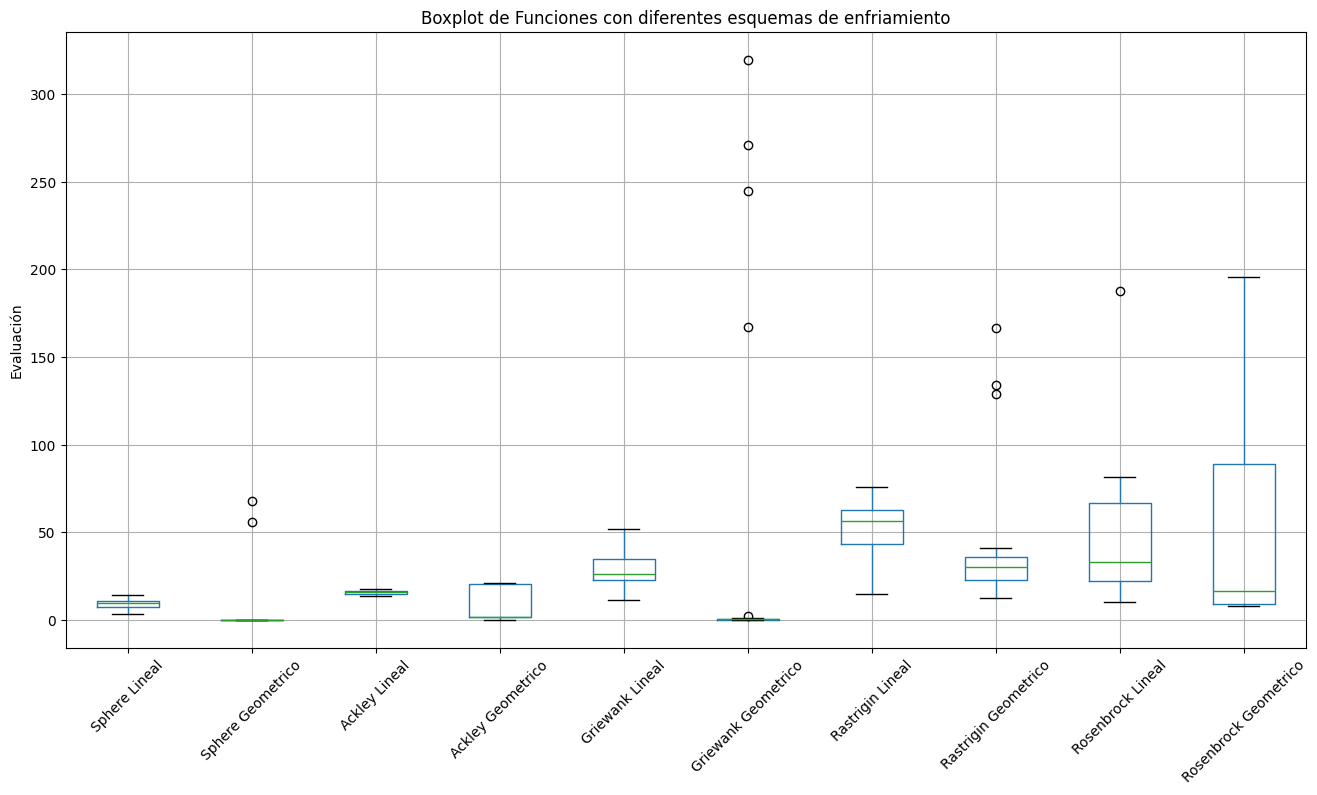

In [65]:
# Ahora hacemos el boxplot, priero convirtiendo el diccionario en dataframe
Datos_SA = pd.DataFrame(funciones)

# %%
plt.figure(figsize=(16, 8))
Datos_SA.boxplot()
plt.title('Boxplot de Funciones con diferentes esquemas de enfriamiento')
plt.ylabel('Evaluación')
plt.xticks(rotation=45)


## Ahora mediremos entropia y diversidad de una ejecucion en especifico

### Ackley Lineal

In [119]:
# Usaremos la primera ejecucion de Ackley lineal, # Semilla: 1730097682
np.random.seed(1730097682)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Ackley, intervaloAckley, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )



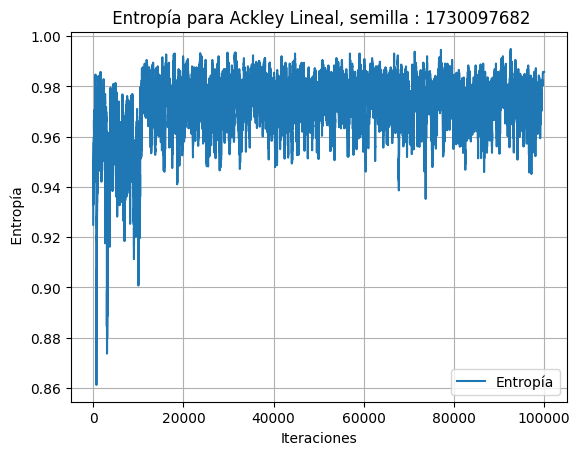

In [120]:
# Graficar Entropía

plt.plot(entropia_AL, label='Entropía')
plt.title(' Entropía para Ackley Lineal, semilla : 1730097682')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

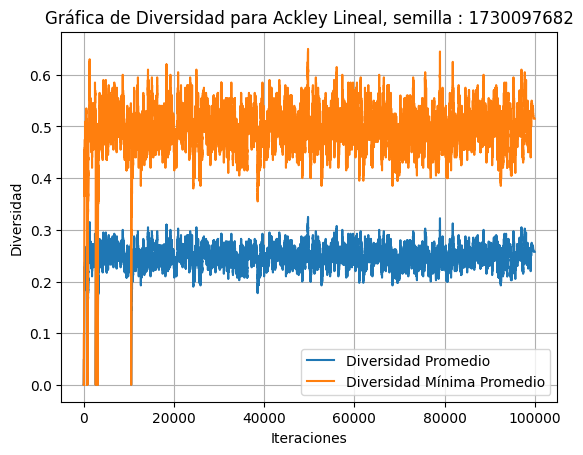

In [122]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL,  label='Diversidad Promedio')
plt.plot(diversidad_min_AL,  label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Ackley Lineal, semilla : 1730097682')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

### Ackley geometrico

In [123]:
# Usaremos la primera ejecucion de Ackley lineal, # Semilla: 1730097702
np.random.seed(1730097682)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Ackley, intervaloAckley, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )

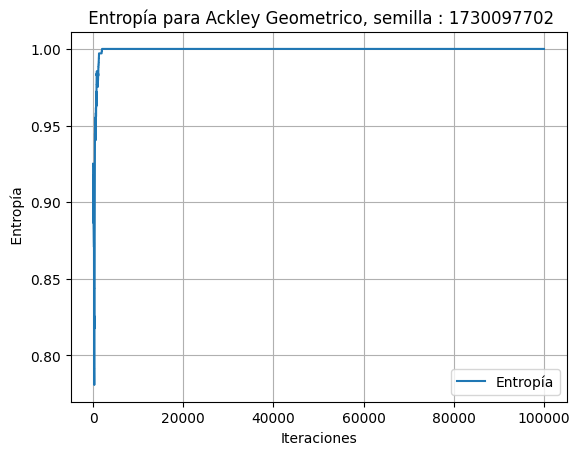

In [124]:
# Graficar Entropía

plt.plot(entropia_AL, label='Entropía')
plt.title(' Entropía para Ackley Geometrico, semilla : 1730097702')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

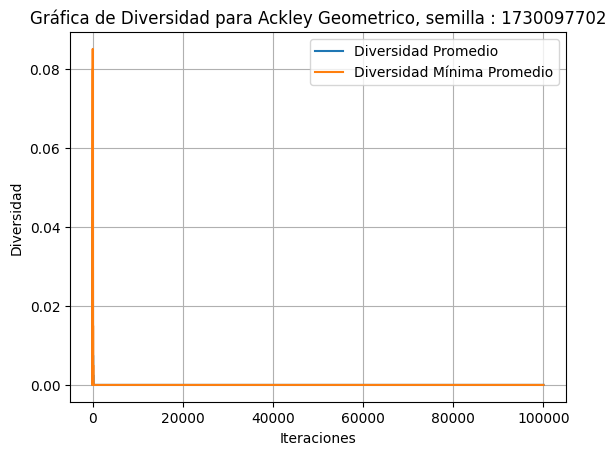

In [125]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL,  label='Diversidad Promedio')
plt.plot(diversidad_min_AL, label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Ackley Geometrico, semilla : 1730097702')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

In [126]:
# Usaremos la primera ejecucion de Griewank lineal, # Semilla: 1730097722
np.random.seed(1730097682)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Griewank, intervaloGriewank, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )


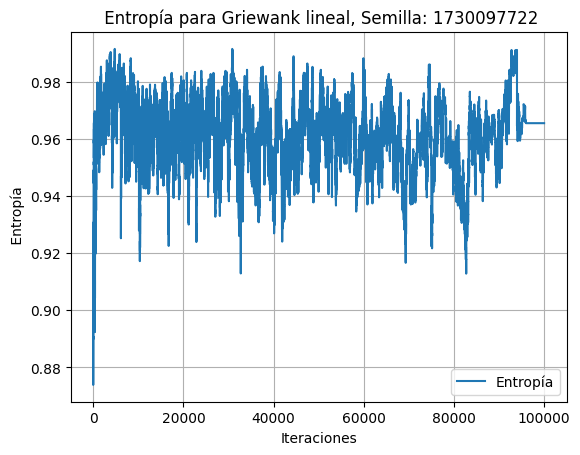

In [127]:
# Graficar Entropía

plt.plot(entropia_AL,  label='Entropía')
plt.title(' Entropía para Griewank lineal, Semilla: 1730097722')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

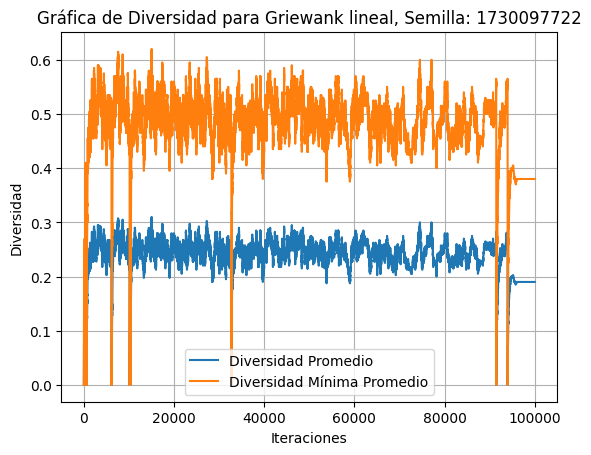

In [128]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL, label='Diversidad Promedio')
plt.plot(diversidad_min_AL,  label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Griewank lineal, Semilla: 1730097722')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

In [129]:
# Usaremos la primera ejecucion de Griewank geometrico, Semilla: 1730097744
np.random.seed(1730097682)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Griewank, intervaloGriewank, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )


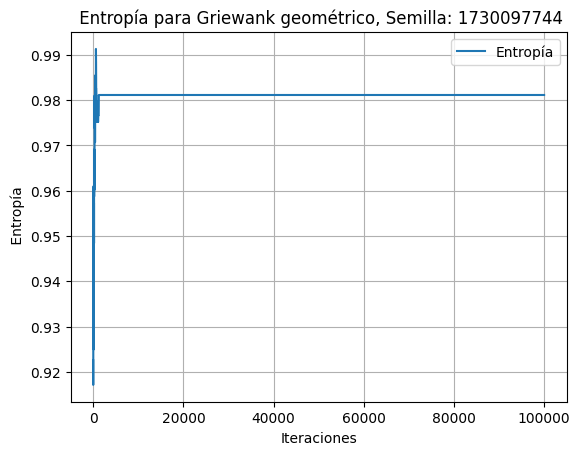

In [130]:
# Graficar Entropía

plt.plot(entropia_AL, label='Entropía')
plt.title(' Entropía para Griewank geométrico, Semilla: 1730097744')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

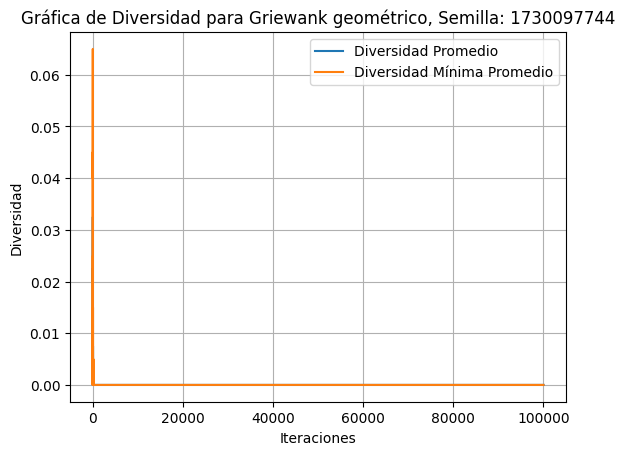

In [131]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL,  label='Diversidad Promedio')
plt.plot(diversidad_min_AL, label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Griewank geométrico, Semilla: 1730097744')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

In [151]:
# Usaremos la primera ejecucion de Rastrigin geometrico, Semilla: 1730097818
np.random.seed(1730097818)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Rastrigin, intervaloRastrigin, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )


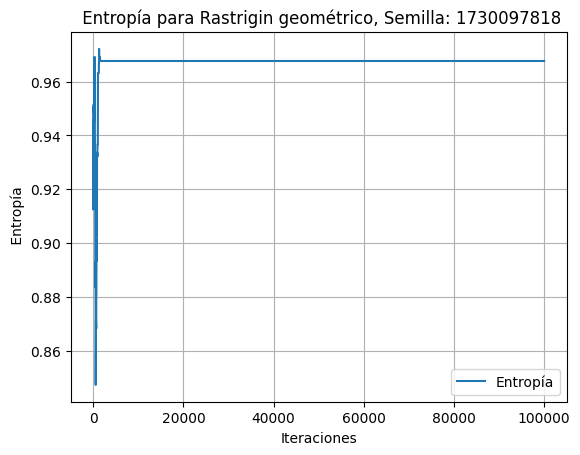

In [152]:
# Graficar Entropía

plt.plot(entropia_AL, label='Entropía')
plt.title(' Entropía para Rastrigin geométrico, Semilla: 1730097818')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

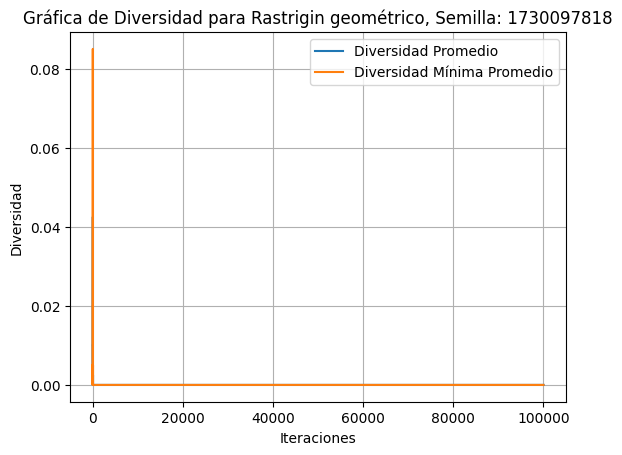

In [153]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL, label='Diversidad Promedio')
plt.plot(diversidad_min_AL,  label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Rastrigin geométrico, Semilla: 1730097818')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

In [135]:
# Usaremos la primera ejecucion de Rastrigin lineal, Semilla: 1730097799
np.random.seed(1730097818)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Rastrigin, intervaloRastrigin, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )

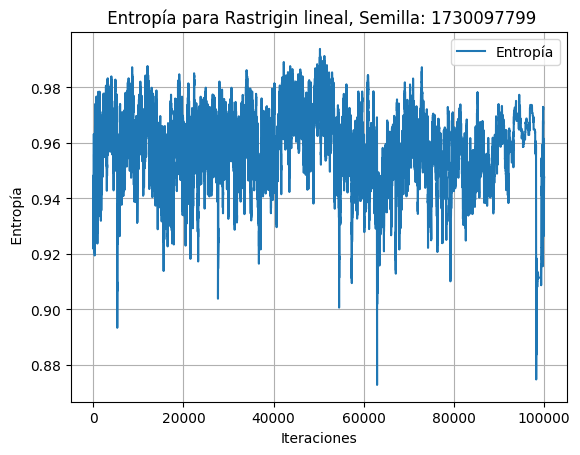

In [136]:
# Graficar Entropía

plt.plot(entropia_AL,  label='Entropía')
plt.title(' Entropía para Rastrigin lineal, Semilla: 1730097799')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

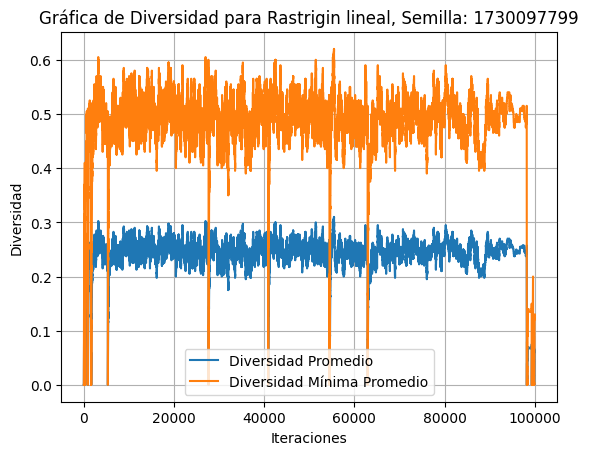

In [137]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL, label='Diversidad Promedio')
plt.plot(diversidad_min_AL,  label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Rastrigin lineal, Semilla: 1730097799')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

In [138]:
# Usaremos la primera ejecucion de Rosenbrock lineal, # Semilla: 1730097765
np.random.seed(1730097765)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Rosenbrock, intervaloRosenbrock, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )

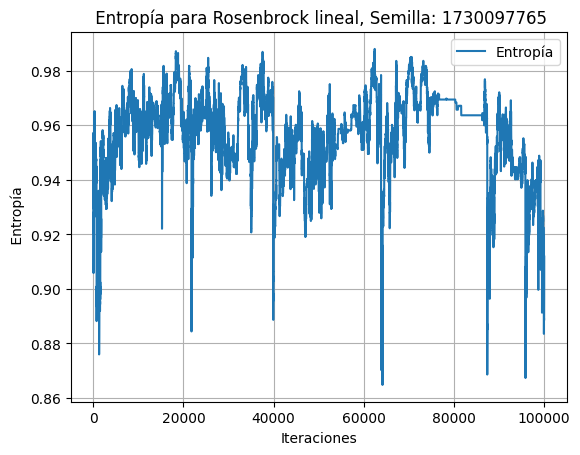

In [139]:
# Graficar Entropía

plt.plot(entropia_AL, label='Entropía')
plt.title(' Entropía para Rosenbrock lineal, Semilla: 1730097765')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

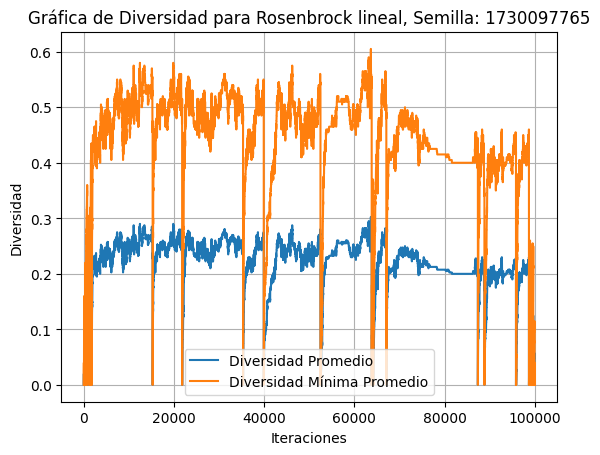

In [140]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL, label='Diversidad Promedio')
plt.plot(diversidad_min_AL,  label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Rosenbrock lineal, Semilla: 1730097765')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

In [141]:
# Usaremos la primera ejecucion de Rosenbrock geometrico, # Semilla: 1730097782
np.random.seed(1730097765)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Rosenbrock, intervaloRosenbrock, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )

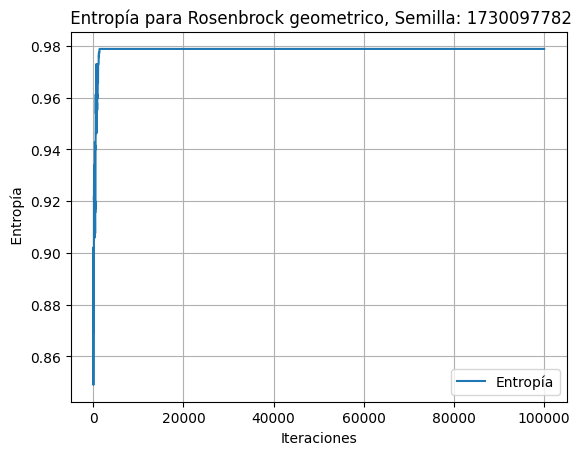

In [142]:
# Graficar Entropía

plt.plot(entropia_AL,  label='Entropía')
plt.title(' Entropía para Rosenbrock geometrico, Semilla: 1730097782')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

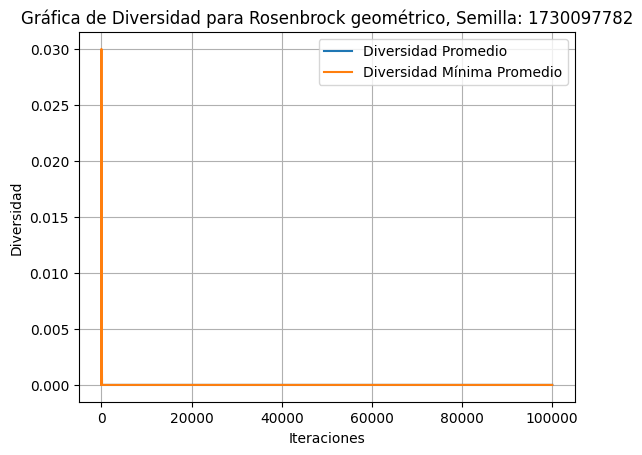

In [143]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL,  label='Diversidad Promedio')
plt.plot(diversidad_min_AL,  label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Rosenbrock geométrico, Semilla: 1730097782')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

In [154]:
# Usaremos la primera ejecucion de Rosenbrock geometrico, # Semilla: 1730097853
np.random.seed(1730097853)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Sphere, intervaloSphere, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Geometrico')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )

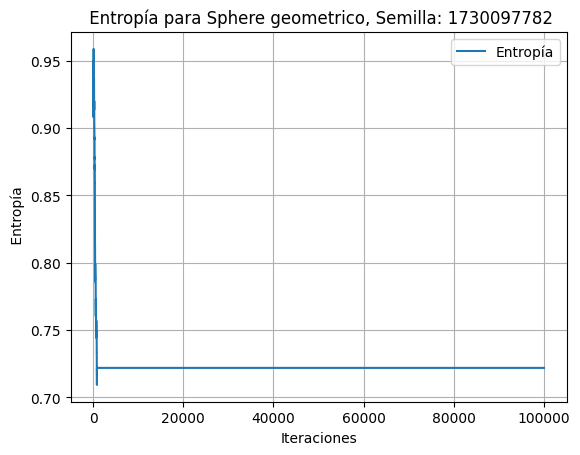

In [155]:
# Graficar Entropía

plt.plot(entropia_AL,  label='Entropía')
plt.title(' Entropía para Sphere geometrico, Semilla: 1730097782')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

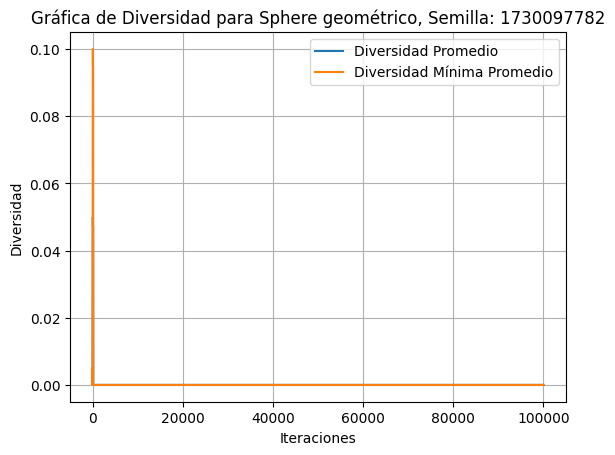

In [156]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL,  label='Diversidad Promedio')
plt.plot(diversidad_min_AL, label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Sphere geométrico, Semilla: 1730097782')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()

In [147]:
# Usaremos la primera ejecucion de Rosenbrock geometrico, # Semilla: 1730097799
np.random.seed(1730097799)
iteraciones = 100000
mejores_soluciones_binariasAL, mejores_evaluacionesAL, activas_soluciones_binariasAL, activas_evaluacionesAL = Recocido_Simulado(Sphere, intervaloSphere, dimension, n_bits, 
                                                                                                                                 iteraciones, T_inicial, 'Lineal')
entropia_AL = np.zeros(iteraciones)
diversidad_promedio_AL = np.zeros(iteraciones)
diversidad_min_AL = np.zeros(iteraciones)

for i in range(iteraciones):
    entropia_AL[i] = Entropia_Total(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_promedio_AL[i] = diversidad_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )
    diversidad_min_AL[i] = diversidad_minima_promedio(np.array([ mejores_soluciones_binariasAL[i], activas_soluciones_binariasAL[i]]) )

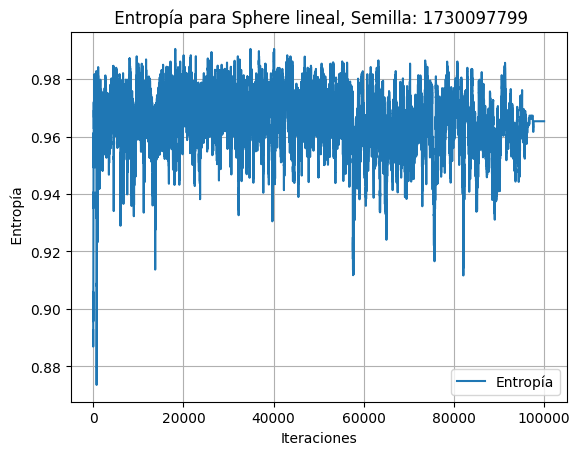

In [148]:
# Graficar Entropía

plt.plot(entropia_AL,  label='Entropía')
plt.title(' Entropía para Sphere lineal, Semilla: 1730097799')
plt.xlabel('Iteraciones')
plt.ylabel(' Entropía')
plt.grid()
plt.legend()

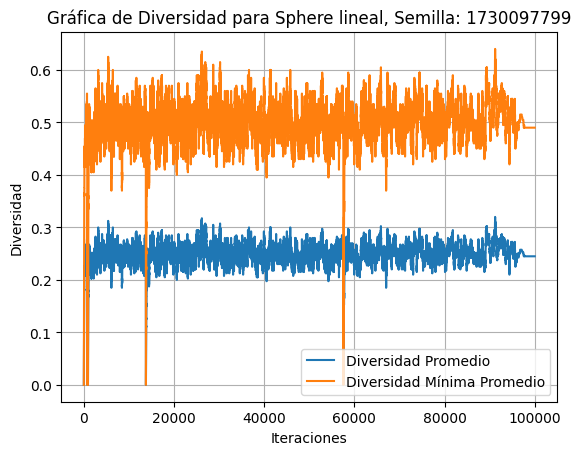

In [149]:
# Graficar Diversidad

plt.plot(diversidad_promedio_AL,  label='Diversidad Promedio')
plt.plot(diversidad_min_AL, label='Diversidad Mínima Promedio')
plt.title('Gráfica de Diversidad para Sphere lineal, Semilla: 1730097799')
plt.xlabel('Iteraciones')
plt.ylabel('Diversidad')
plt.grid()
plt.legend()